In [5]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import time
from openpyxl import Workbook

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [6]:
# # Membaca data dari file CSV
# df = pd.read_csv('DataReady.csv', parse_dates=['Date'])
# df.columns = ['ds', 'y']
# print(df.sample(5))

In [7]:
# Membaca data dari file CSV
df = pd.read_csv('DataT.csv', parse_dates=['Date'])

# Menyesuaikan format kolom sesuai Prophet
df['ds'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')


df = df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.columns = ['y', 'ds']

# Membersihkan data dari nilai kosong
df = df.dropna()

# Menampilkan sampel data
print("Sampel Data:")
print(df.sample(5))


NameError: name 'pd' is not defined

In [4]:
# Membagi data menjadi data latih dan uji
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Menampilkan sampel data latih dan uji
print("Data Latih:")
print(train_data.head())
print("Data Uji:")
print(test_data.head())

print("Jumlah baris pada test_data:", train_data.shape[0])
print("Jumlah baris pada test_data:", test_data.shape[0])

Data Latih:
      y         ds
0  3090 2020-07-13
1  3080 2020-07-14
2  3090 2020-07-15
3  3100 2020-07-16
4  3060 2020-07-17
Data Uji:
        y         ds
772  3720 2023-09-15
773  3680 2023-09-18
774  3730 2023-09-19
775  3810 2023-09-20
776  3810 2023-09-21
Jumlah baris pada test_data: 772
Jumlah baris pada test_data: 193


In [5]:
# Membuat dan melatih model Prophet tanpa tuning
model_default = Prophet()

# Mengukur waktu pelatihan
start_time = time.time()
model_default.fit(train_data)
end_time = time.time()

print(f"Waktu pelatihan model tanpa tuning: {end_time - start_time:.2f} detik")


03:09:21 - cmdstanpy - INFO - Chain [1] start processing
03:09:22 - cmdstanpy - INFO - Chain [1] done processing


Waktu pelatihan model tanpa tuning: 1.64 detik


In [6]:
# Membuat DataFrame untuk prediksi
future = model_default.make_future_dataframe(periods=193)

# Melakukan prediksi tanpa tuning
forecast_default = model_default.predict(future)

# Menampilkan hasil prediksi
print("Hasil Prediksi Tanpa Tuning:")
print(forecast_default[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Hasil Prediksi Tanpa Tuning:
          ds         yhat   yhat_lower   yhat_upper
0 2020-07-13  3025.413914  2880.140857  3152.778411
1 2020-07-14  3016.364853  2885.165344  3158.040224
2 2020-07-15  3017.324777  2866.324714  3155.682452
3 2020-07-16  3020.949049  2877.710449  3166.246479
4 2020-07-17  3017.230313  2877.009156  3164.248138


In [7]:
# Parameter grid untuk random search
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.1, 0.15, 0.2],
    'seasonality_prior_scale': [0.005, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [0.08, 0.09, 0.1, 0.11, 0.12],
    'interval_width': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
}

random_search = list(ParameterSampler(param_grid, n_iter=1400, random_state=42))

best_params = None
best_mape = float('inf')
best_trial = None
results = []

# Iterasi yang ingin disimpan hasil prediksinya
target_iters = [150, 300, 450, 600, 750, 900]

# List untuk menyimpan hasil prediksi dan parameter dari iterasi target
first_6_forecasts = []

first_6_params = []

start_time = time.time()

for i, params in enumerate(random_search, 1):
    print(f"Testing parameters ({i}): {params}")

    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        holidays_prior_scale=params['holidays_prior_scale'],
        interval_width=params['interval_width']
    )

    model.fit(train_data)
    forecast = model.predict(future)

    test_forecast = forecast[forecast['ds'].isin(test_data['ds'])].copy()
    test_actual = test_data[test_data['ds'].isin(test_forecast['ds'])].copy()

    if len(test_forecast) != len(test_actual):
        print(f"Skipping due to mismatched samples: {len(test_forecast)} vs {len(test_actual)}")
        continue

    # Simpan hasil prediksi dan parameter dari iterasi tertentu
    if i in target_iters:
        # Simpan prediksi
        test_forecast_copy = test_forecast[['ds', 'yhat']].copy()
        test_forecast_copy.columns = ['ds', f'yhat_iterasi_{i}']
        first_6_forecasts.append(test_forecast_copy)

        # Simpan parameter
        param_copy = params.copy()
        param_copy['iterasi'] = i
        first_6_params.append(param_copy)

    # Hitung MAPE
    mape = mean_absolute_percentage_error(test_actual['y'], test_forecast['yhat']) * 100
    results.append({"percobaan ke-n": i, "nilai MAPE": mape})

    # Simpan parameter terbaik
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_trial = i

end_time = time.time()

# Cetak hasil terbaik
print(f"\nParameter Terbaik: {best_params}")
print(f"MAPE Terbaik: {best_mape:.2f}%")
print(f"MAPE terbaik ditemukan pada percobaan ke-{best_trial}")
print(f"Waktu yang dibutuhkan untuk tuning: {end_time - start_time:.2f} detik")


Testing parameters (1): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:23 - cmdstanpy - INFO - Chain [1] start processing
03:09:23 - cmdstanpy - INFO - Chain [1] done processing
03:09:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (2): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:24 - cmdstanpy - INFO - Chain [1] done processing
03:09:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (3): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:24 - cmdstanpy - INFO - Chain [1] done processing
03:09:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (4): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:25 - cmdstanpy - INFO - Chain [1] done processing
03:09:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (5): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:25 - cmdstanpy - INFO - Chain [1] done processing
03:09:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (6): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:26 - cmdstanpy - INFO - Chain [1] done processing
03:09:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (7): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:26 - cmdstanpy - INFO - Chain [1] done processing
03:09:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (8): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:27 - cmdstanpy - INFO - Chain [1] done processing
03:09:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (9): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:27 - cmdstanpy - INFO - Chain [1] done processing
03:09:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (10): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:28 - cmdstanpy - INFO - Chain [1] done processing
03:09:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (11): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:29 - cmdstanpy - INFO - Chain [1] done processing
03:09:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (12): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (13): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:30 - cmdstanpy - INFO - Chain [1] start processing
03:09:30 - cmdstanpy - INFO - Chain [1] done processing
03:09:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (14): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:30 - cmdstanpy - INFO - Chain [1] done processing
03:09:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (15): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (16): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:31 - cmdstanpy - INFO - Chain [1] start processing
03:09:31 - cmdstanpy - INFO - Chain [1] done processing
03:09:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (17): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (18): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:32 - cmdstanpy - INFO - Chain [1] start processing
03:09:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (19): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:33 - cmdstanpy - INFO - Chain [1] start processing
03:09:33 - cmdstanpy - INFO - Chain [1] done processing
03:09:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (20): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:33 - cmdstanpy - INFO - Chain [1] done processing
03:09:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (21): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:34 - cmdstanpy - INFO - Chain [1] done processing
03:09:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (22): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:35 - cmdstanpy - INFO - Chain [1] done processing
03:09:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (23): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:35 - cmdstanpy - INFO - Chain [1] done processing
03:09:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (24): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:36 - cmdstanpy - INFO - Chain [1] done processing
03:09:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (25): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:36 - cmdstanpy - INFO - Chain [1] done processing
03:09:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (26): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:37 - cmdstanpy - INFO - Chain [1] done processing
03:09:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (27): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:38 - cmdstanpy - INFO - Chain [1] done processing
03:09:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (28): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:38 - cmdstanpy - INFO - Chain [1] done processing
03:09:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (29): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:39 - cmdstanpy - INFO - Chain [1] done processing
03:09:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (30): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:39 - cmdstanpy - INFO - Chain [1] done processing
03:09:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (31): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:40 - cmdstanpy - INFO - Chain [1] done processing
03:09:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (32): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:40 - cmdstanpy - INFO - Chain [1] done processing
03:09:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (33): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:41 - cmdstanpy - INFO - Chain [1] done processing
03:09:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (34): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:41 - cmdstanpy - INFO - Chain [1] done processing
03:09:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (35): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (36): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:42 - cmdstanpy - INFO - Chain [1] start processing
03:09:43 - cmdstanpy - INFO - Chain [1] done processing
03:09:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (37): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:43 - cmdstanpy - INFO - Chain [1] done processing
03:09:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (38): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:44 - cmdstanpy - INFO - Chain [1] done processing
03:09:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (39): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:44 - cmdstanpy - INFO - Chain [1] done processing
03:09:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (40): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:45 - cmdstanpy - INFO - Chain [1] done processing
03:09:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (41): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:45 - cmdstanpy - INFO - Chain [1] done processing
03:09:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (42): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:46 - cmdstanpy - INFO - Chain [1] done processing
03:09:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (43): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:46 - cmdstanpy - INFO - Chain [1] done processing
03:09:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (44): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:47 - cmdstanpy - INFO - Chain [1] done processing
03:09:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (45): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:47 - cmdstanpy - INFO - Chain [1] done processing
03:09:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (46): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (47): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:48 - cmdstanpy - INFO - Chain [1] start processing
03:09:49 - cmdstanpy - INFO - Chain [1] done processing
03:09:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (48): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (49): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:50 - cmdstanpy - INFO - Chain [1] start processing
03:09:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (50): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:51 - cmdstanpy - INFO - Chain [1] start processing
03:09:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (51): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:52 - cmdstanpy - INFO - Chain [1] start processing
03:09:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (52): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:53 - cmdstanpy - INFO - Chain [1] start processing
03:09:53 - cmdstanpy - INFO - Chain [1] done processing
03:09:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (53): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (54): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:54 - cmdstanpy - INFO - Chain [1] start processing
03:09:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (55): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:55 - cmdstanpy - INFO - Chain [1] start processing
03:09:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (56): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:09:56 - cmdstanpy - INFO - Chain [1] start processing
03:09:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (57): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:57 - cmdstanpy - INFO - Chain [1] start processing
03:09:57 - cmdstanpy - INFO - Chain [1] done processing
03:09:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (58): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:57 - cmdstanpy - INFO - Chain [1] done processing
03:09:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (59): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:58 - cmdstanpy - INFO - Chain [1] done processing
03:09:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (60): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:58 - cmdstanpy - INFO - Chain [1] done processing
03:09:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (61): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:59 - cmdstanpy - INFO - Chain [1] done processing
03:09:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (62): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:09:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (63): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:00 - cmdstanpy - INFO - Chain [1] start processing
03:10:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (64): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:01 - cmdstanpy - INFO - Chain [1] start processing
03:10:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (65): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:01 - cmdstanpy - INFO - Chain [1] start processing
03:10:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (66): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:02 - cmdstanpy - INFO - Chain [1] start processing
03:10:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (67): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:03 - cmdstanpy - INFO - Chain [1] start processing
03:10:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (68): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:04 - cmdstanpy - INFO - Chain [1] start processing
03:10:04 - cmdstanpy - INFO - Chain [1] done processing
03:10:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (69): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:04 - cmdstanpy - INFO - Chain [1] done processing
03:10:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (70): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:05 - cmdstanpy - INFO - Chain [1] done processing
03:10:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (71): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (72): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:06 - cmdstanpy - INFO - Chain [1] start processing
03:10:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (73): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:07 - cmdstanpy - INFO - Chain [1] start processing
03:10:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (74): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:08 - cmdstanpy - INFO - Chain [1] start processing
03:10:08 - cmdstanpy - INFO - Chain [1] done processing
03:10:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (75): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:08 - cmdstanpy - INFO - Chain [1] done processing
03:10:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (76): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:09 - cmdstanpy - INFO - Chain [1] done processing
03:10:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (77): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:09 - cmdstanpy - INFO - Chain [1] done processing
03:10:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (78): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (79): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:10 - cmdstanpy - INFO - Chain [1] start processing
03:10:11 - cmdstanpy - INFO - Chain [1] done processing
03:10:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (80): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:11 - cmdstanpy - INFO - Chain [1] done processing
03:10:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (81): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:12 - cmdstanpy - INFO - Chain [1] done processing
03:10:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (82): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (83): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:13 - cmdstanpy - INFO - Chain [1] start processing
03:10:13 - cmdstanpy - INFO - Chain [1] done processing
03:10:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (84): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (85): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:14 - cmdstanpy - INFO - Chain [1] start processing
03:10:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (86): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:15 - cmdstanpy - INFO - Chain [1] start processing
03:10:15 - cmdstanpy - INFO - Chain [1] done processing
03:10:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (87): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (88): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:16 - cmdstanpy - INFO - Chain [1] start processing
03:10:16 - cmdstanpy - INFO - Chain [1] done processing
03:10:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (89): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:17 - cmdstanpy - INFO - Chain [1] done processing
03:10:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (90): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (91): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:18 - cmdstanpy - INFO - Chain [1] start processing
03:10:18 - cmdstanpy - INFO - Chain [1] done processing
03:10:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (92): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (93): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:19 - cmdstanpy - INFO - Chain [1] start processing
03:10:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (94): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:20 - cmdstanpy - INFO - Chain [1] start processing
03:10:20 - cmdstanpy - INFO - Chain [1] done processing
03:10:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (95): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:20 - cmdstanpy - INFO - Chain [1] done processing
03:10:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (96): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (97): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:21 - cmdstanpy - INFO - Chain [1] start processing
03:10:21 - cmdstanpy - INFO - Chain [1] done processing
03:10:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (98): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (99): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:22 - cmdstanpy - INFO - Chain [1] start processing
03:10:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (100): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:23 - cmdstanpy - INFO - Chain [1] start processing
03:10:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (101): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:23 - cmdstanpy - INFO - Chain [1] start processing
03:10:23 - cmdstanpy - INFO - Chain [1] done processing
03:10:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (102): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:24 - cmdstanpy - INFO - Chain [1] done processing
03:10:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (103): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:25 - cmdstanpy - INFO - Chain [1] done processing
03:10:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (104): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:25 - cmdstanpy - INFO - Chain [1] done processing
03:10:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (105): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:26 - cmdstanpy - INFO - Chain [1] done processing
03:10:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (106): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:26 - cmdstanpy - INFO - Chain [1] done processing
03:10:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (107): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:27 - cmdstanpy - INFO - Chain [1] done processing
03:10:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (108): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:27 - cmdstanpy - INFO - Chain [1] done processing
03:10:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (109): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:28 - cmdstanpy - INFO - Chain [1] done processing
03:10:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (110): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:28 - cmdstanpy - INFO - Chain [1] done processing
03:10:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (111): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:29 - cmdstanpy - INFO - Chain [1] done processing
03:10:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (112): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:10:29 - cmdstanpy - INFO - Chain [1] done processing
03:10:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (113): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:30 - cmdstanpy - INFO - Chain [1] done processing
03:10:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (114): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (115): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:31 - cmdstanpy - INFO - Chain [1] start processing
03:10:31 - cmdstanpy - INFO - Chain [1] done processing
03:10:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (116): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:31 - cmdstanpy - INFO - Chain [1] done processing
03:10:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (117): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:32 - cmdstanpy - INFO - Chain [1] done processing
03:10:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (118): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:32 - cmdstanpy - INFO - Chain [1] done processing
03:10:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (119): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (120): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:34 - cmdstanpy - INFO - Chain [1] start processing
03:10:34 - cmdstanpy - INFO - Chain [1] done processing
03:10:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (121): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:34 - cmdstanpy - INFO - Chain [1] done processing
03:10:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (122): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:35 - cmdstanpy - INFO - Chain [1] done processing
03:10:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (123): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:35 - cmdstanpy - INFO - Chain [1] done processing
03:10:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (124): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:36 - cmdstanpy - INFO - Chain [1] done processing
03:10:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (125): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:36 - cmdstanpy - INFO - Chain [1] done processing
03:10:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (126): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:37 - cmdstanpy - INFO - Chain [1] done processing
03:10:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (127): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:37 - cmdstanpy - INFO - Chain [1] done processing
03:10:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (128): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:38 - cmdstanpy - INFO - Chain [1] done processing
03:10:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (129): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (130): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:39 - cmdstanpy - INFO - Chain [1] start processing
03:10:39 - cmdstanpy - INFO - Chain [1] done processing
03:10:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (131): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:39 - cmdstanpy - INFO - Chain [1] done processing
03:10:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (132): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:40 - cmdstanpy - INFO - Chain [1] done processing
03:10:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (133): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:40 - cmdstanpy - INFO - Chain [1] done processing
03:10:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (134): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:41 - cmdstanpy - INFO - Chain [1] done processing
03:10:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (135): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:41 - cmdstanpy - INFO - Chain [1] done processing
03:10:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (136): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:42 - cmdstanpy - INFO - Chain [1] done processing
03:10:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (137): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:43 - cmdstanpy - INFO - Chain [1] done processing
03:10:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (138): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:43 - cmdstanpy - INFO - Chain [1] done processing
03:10:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (139): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (140): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:44 - cmdstanpy - INFO - Chain [1] start processing
03:10:44 - cmdstanpy - INFO - Chain [1] done processing
03:10:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (141): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:45 - cmdstanpy - INFO - Chain [1] done processing
03:10:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (142): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:45 - cmdstanpy - INFO - Chain [1] done processing
03:10:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (143): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:46 - cmdstanpy - INFO - Chain [1] done processing
03:10:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (144): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:46 - cmdstanpy - INFO - Chain [1] done processing
03:10:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (145): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:47 - cmdstanpy - INFO - Chain [1] done processing
03:10:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (146): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:47 - cmdstanpy - INFO - Chain [1] done processing
03:10:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (147): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (148): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:48 - cmdstanpy - INFO - Chain [1] start processing
03:10:48 - cmdstanpy - INFO - Chain [1] done processing
03:10:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (149): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (150): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:49 - cmdstanpy - INFO - Chain [1] start processing
03:10:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (151): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:50 - cmdstanpy - INFO - Chain [1] start processing
03:10:50 - cmdstanpy - INFO - Chain [1] done processing
03:10:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (152): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:51 - cmdstanpy - INFO - Chain [1] done processing
03:10:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (153): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (154): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:52 - cmdstanpy - INFO - Chain [1] start processing
03:10:52 - cmdstanpy - INFO - Chain [1] done processing
03:10:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (155): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:52 - cmdstanpy - INFO - Chain [1] done processing
03:10:53 - cmdstanpy - INFO - Chain [1] start processing
03:10:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (156): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (157): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:53 - cmdstanpy - INFO - Chain [1] done processing
03:10:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (158): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (159): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:54 - cmdstanpy - INFO - Chain [1] start processing
03:10:54 - cmdstanpy - INFO - Chain [1] done processing
03:10:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (160): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:55 - cmdstanpy - INFO - Chain [1] done processing
03:10:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (161): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:56 - cmdstanpy - INFO - Chain [1] done processing
03:10:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (162): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:56 - cmdstanpy - INFO - Chain [1] done processing
03:10:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (163): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:57 - cmdstanpy - INFO - Chain [1] done processing
03:10:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (164): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (165): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:58 - cmdstanpy - INFO - Chain [1] start processing
03:10:58 - cmdstanpy - INFO - Chain [1] done processing
03:10:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (166): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:58 - cmdstanpy - INFO - Chain [1] done processing
03:10:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (167): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:59 - cmdstanpy - INFO - Chain [1] done processing
03:10:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (168): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:10:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (169): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:00 - cmdstanpy - INFO - Chain [1] start processing
03:11:00 - cmdstanpy - INFO - Chain [1] done processing
03:11:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (170): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (171): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:01 - cmdstanpy - INFO - Chain [1] start processing
03:11:01 - cmdstanpy - INFO - Chain [1] done processing
03:11:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (172): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:01 - cmdstanpy - INFO - Chain [1] done processing
03:11:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (173): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:02 - cmdstanpy - INFO - Chain [1] done processing
03:11:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (174): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (175): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:03 - cmdstanpy - INFO - Chain [1] start processing
03:11:03 - cmdstanpy - INFO - Chain [1] done processing
03:11:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (176): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:03 - cmdstanpy - INFO - Chain [1] done processing
03:11:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (177): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:04 - cmdstanpy - INFO - Chain [1] done processing
03:11:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (178): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:05 - cmdstanpy - INFO - Chain [1] done processing
03:11:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (179): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:05 - cmdstanpy - INFO - Chain [1] done processing
03:11:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (180): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:06 - cmdstanpy - INFO - Chain [1] done processing
03:11:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (181): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:06 - cmdstanpy - INFO - Chain [1] done processing
03:11:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (182): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:07 - cmdstanpy - INFO - Chain [1] done processing
03:11:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (183): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:07 - cmdstanpy - INFO - Chain [1] done processing
03:11:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (184): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:08 - cmdstanpy - INFO - Chain [1] done processing
03:11:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (185): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:08 - cmdstanpy - INFO - Chain [1] done processing
03:11:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (186): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:09 - cmdstanpy - INFO - Chain [1] done processing
03:11:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (187): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (188): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:10 - cmdstanpy - INFO - Chain [1] start processing
03:11:10 - cmdstanpy - INFO - Chain [1] done processing
03:11:10 - cmdstanpy - INFO - Chain [1] start processing
03:11:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (189): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (190): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (191): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:11 - cmdstanpy - INFO - Chain [1] start processing
03:11:11 - cmdstanpy - INFO - Chain [1] done processing
03:11:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (192): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:12 - cmdstanpy - INFO - Chain [1] done processing
03:11:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (193): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:12 - cmdstanpy - INFO - Chain [1] done processing
03:11:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (194): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:13 - cmdstanpy - INFO - Chain [1] done processing
03:11:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (195): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:13 - cmdstanpy - INFO - Chain [1] done processing
03:11:14 - cmdstanpy - INFO - Chain [1] start processing
03:11:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (196): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (197): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:14 - cmdstanpy - INFO - Chain [1] done processing
03:11:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (198): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:15 - cmdstanpy - INFO - Chain [1] done processing
03:11:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (199): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:15 - cmdstanpy - INFO - Chain [1] done processing
03:11:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (200): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:16 - cmdstanpy - INFO - Chain [1] done processing
03:11:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (201): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:16 - cmdstanpy - INFO - Chain [1] done processing
03:11:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (202): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:17 - cmdstanpy - INFO - Chain [1] done processing
03:11:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (203): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:17 - cmdstanpy - INFO - Chain [1] done processing
03:11:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (204): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:18 - cmdstanpy - INFO - Chain [1] done processing
03:11:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (205): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:18 - cmdstanpy - INFO - Chain [1] done processing
03:11:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (206): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:19 - cmdstanpy - INFO - Chain [1] done processing
03:11:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (207): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:19 - cmdstanpy - INFO - Chain [1] done processing
03:11:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (208): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:20 - cmdstanpy - INFO - Chain [1] done processing
03:11:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (209): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:20 - cmdstanpy - INFO - Chain [1] done processing
03:11:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (210): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:21 - cmdstanpy - INFO - Chain [1] done processing
03:11:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (211): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:21 - cmdstanpy - INFO - Chain [1] done processing
03:11:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (212): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:22 - cmdstanpy - INFO - Chain [1] done processing
03:11:22 - cmdstanpy - INFO - Chain [1] start processing
03:11:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (213): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (214): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:23 - cmdstanpy - INFO - Chain [1] done processing
03:11:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (215): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:23 - cmdstanpy - INFO - Chain [1] done processing
03:11:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (216): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:24 - cmdstanpy - INFO - Chain [1] done processing
03:11:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (217): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:25 - cmdstanpy - INFO - Chain [1] done processing
03:11:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (218): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:25 - cmdstanpy - INFO - Chain [1] done processing
03:11:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (219): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:26 - cmdstanpy - INFO - Chain [1] done processing
03:11:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (220): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:26 - cmdstanpy - INFO - Chain [1] done processing
03:11:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (221): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:26 - cmdstanpy - INFO - Chain [1] done processing
03:11:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (222): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:27 - cmdstanpy - INFO - Chain [1] done processing
03:11:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (223): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (224): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:11:28 - cmdstanpy - INFO - Chain [1] start processing
03:11:28 - cmdstanpy - INFO - Chain [1] done processing
03:11:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (225): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:28 - cmdstanpy - INFO - Chain [1] done processing
03:11:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (226): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:29 - cmdstanpy - INFO - Chain [1] done processing
03:11:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (227): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:29 - cmdstanpy - INFO - Chain [1] done processing
03:11:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (228): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:30 - cmdstanpy - INFO - Chain [1] done processing
03:11:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (229): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:31 - cmdstanpy - INFO - Chain [1] done processing
03:11:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (230): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (231): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:32 - cmdstanpy - INFO - Chain [1] start processing
03:11:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (232): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:32 - cmdstanpy - INFO - Chain [1] start processing
03:11:32 - cmdstanpy - INFO - Chain [1] done processing
03:11:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (233): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:33 - cmdstanpy - INFO - Chain [1] done processing
03:11:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (234): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:33 - cmdstanpy - INFO - Chain [1] done processing
03:11:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (235): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:34 - cmdstanpy - INFO - Chain [1] done processing
03:11:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (236): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:34 - cmdstanpy - INFO - Chain [1] done processing
03:11:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (237): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:35 - cmdstanpy - INFO - Chain [1] done processing
03:11:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (238): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:35 - cmdstanpy - INFO - Chain [1] done processing
03:11:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (239): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:36 - cmdstanpy - INFO - Chain [1] done processing
03:11:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (240): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:36 - cmdstanpy - INFO - Chain [1] done processing
03:11:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (241): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:37 - cmdstanpy - INFO - Chain [1] done processing
03:11:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (242): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:37 - cmdstanpy - INFO - Chain [1] done processing
03:11:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (243): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:38 - cmdstanpy - INFO - Chain [1] done processing
03:11:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (244): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:38 - cmdstanpy - INFO - Chain [1] done processing
03:11:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (245): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:39 - cmdstanpy - INFO - Chain [1] done processing
03:11:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (246): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:39 - cmdstanpy - INFO - Chain [1] done processing
03:11:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (247): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:40 - cmdstanpy - INFO - Chain [1] done processing
03:11:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (248): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:40 - cmdstanpy - INFO - Chain [1] done processing
03:11:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (249): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:41 - cmdstanpy - INFO - Chain [1] done processing
03:11:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (250): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:41 - cmdstanpy - INFO - Chain [1] done processing
03:11:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (251): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:42 - cmdstanpy - INFO - Chain [1] done processing
03:11:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (252): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:42 - cmdstanpy - INFO - Chain [1] done processing
03:11:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (253): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (254): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:43 - cmdstanpy - INFO - Chain [1] start processing
03:11:43 - cmdstanpy - INFO - Chain [1] done processing
03:11:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (255): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:44 - cmdstanpy - INFO - Chain [1] done processing
03:11:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (256): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:44 - cmdstanpy - INFO - Chain [1] done processing
03:11:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (257): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:45 - cmdstanpy - INFO - Chain [1] done processing
03:11:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (258): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:45 - cmdstanpy - INFO - Chain [1] done processing
03:11:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (259): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:46 - cmdstanpy - INFO - Chain [1] done processing
03:11:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (260): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (261): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:47 - cmdstanpy - INFO - Chain [1] start processing
03:11:47 - cmdstanpy - INFO - Chain [1] done processing
03:11:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (262): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:47 - cmdstanpy - INFO - Chain [1] done processing
03:11:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (263): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:48 - cmdstanpy - INFO - Chain [1] done processing
03:11:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (264): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:48 - cmdstanpy - INFO - Chain [1] done processing
03:11:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (265): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:49 - cmdstanpy - INFO - Chain [1] done processing
03:11:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (266): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:49 - cmdstanpy - INFO - Chain [1] done processing
03:11:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (267): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:50 - cmdstanpy - INFO - Chain [1] done processing
03:11:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (268): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:50 - cmdstanpy - INFO - Chain [1] done processing
03:11:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (269): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:51 - cmdstanpy - INFO - Chain [1] done processing
03:11:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (270): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:51 - cmdstanpy - INFO - Chain [1] done processing
03:11:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (271): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:52 - cmdstanpy - INFO - Chain [1] done processing
03:11:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (272): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:52 - cmdstanpy - INFO - Chain [1] done processing
03:11:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (273): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:53 - cmdstanpy - INFO - Chain [1] done processing
03:11:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (274): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:53 - cmdstanpy - INFO - Chain [1] done processing
03:11:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (275): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:54 - cmdstanpy - INFO - Chain [1] done processing
03:11:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (276): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:54 - cmdstanpy - INFO - Chain [1] done processing
03:11:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (277): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:55 - cmdstanpy - INFO - Chain [1] done processing
03:11:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (278): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:55 - cmdstanpy - INFO - Chain [1] done processing
03:11:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (279): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:56 - cmdstanpy - INFO - Chain [1] done processing
03:11:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (280): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:11:56 - cmdstanpy - INFO - Chain [1] done processing
03:11:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (281): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:11:57 - cmdstanpy - INFO - Chain [1] done processing
03:11:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (282): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:11:58 - cmdstanpy - INFO - Chain [1] done processing
03:11:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (283): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:11:58 - cmdstanpy - INFO - Chain [1] done processing
03:11:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (284): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:11:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (285): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:00 - cmdstanpy - INFO - Chain [1] start processing
03:12:00 - cmdstanpy - INFO - Chain [1] done processing
03:12:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (286): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:01 - cmdstanpy - INFO - Chain [1] done processing
03:12:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (287): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (288): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:02 - cmdstanpy - INFO - Chain [1] start processing
03:12:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (289): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:03 - cmdstanpy - INFO - Chain [1] start processing
03:12:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (290): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:04 - cmdstanpy - INFO - Chain [1] start processing
03:12:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (291): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:05 - cmdstanpy - INFO - Chain [1] start processing
03:12:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (292): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:06 - cmdstanpy - INFO - Chain [1] start processing
03:12:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (293): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:07 - cmdstanpy - INFO - Chain [1] start processing
03:12:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (294): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:08 - cmdstanpy - INFO - Chain [1] start processing
03:12:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (295): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:09 - cmdstanpy - INFO - Chain [1] start processing
03:12:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (296): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:10 - cmdstanpy - INFO - Chain [1] start processing
03:12:10 - cmdstanpy - INFO - Chain [1] done processing
03:12:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (297): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (298): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:12 - cmdstanpy - INFO - Chain [1] start processing
03:12:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (299): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:14 - cmdstanpy - INFO - Chain [1] start processing
03:12:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (300): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:15 - cmdstanpy - INFO - Chain [1] start processing
03:12:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (301): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:16 - cmdstanpy - INFO - Chain [1] start processing
03:12:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (302): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:18 - cmdstanpy - INFO - Chain [1] start processing
03:12:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (303): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:19 - cmdstanpy - INFO - Chain [1] start processing
03:12:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (304): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:20 - cmdstanpy - INFO - Chain [1] start processing
03:12:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (305): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:21 - cmdstanpy - INFO - Chain [1] start processing
03:12:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (306): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:23 - cmdstanpy - INFO - Chain [1] start processing
03:12:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (307): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:24 - cmdstanpy - INFO - Chain [1] start processing
03:12:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (308): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:25 - cmdstanpy - INFO - Chain [1] start processing
03:12:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (309): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:26 - cmdstanpy - INFO - Chain [1] start processing
03:12:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (310): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:28 - cmdstanpy - INFO - Chain [1] start processing
03:12:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (311): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:29 - cmdstanpy - INFO - Chain [1] start processing
03:12:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (312): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:30 - cmdstanpy - INFO - Chain [1] start processing
03:12:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (313): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:31 - cmdstanpy - INFO - Chain [1] start processing
03:12:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (314): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:32 - cmdstanpy - INFO - Chain [1] start processing
03:12:32 - cmdstanpy - INFO - Chain [1] done processing
03:12:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (315): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:33 - cmdstanpy - INFO - Chain [1] done processing
03:12:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (316): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:34 - cmdstanpy - INFO - Chain [1] done processing
03:12:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (317): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:34 - cmdstanpy - INFO - Chain [1] done processing
03:12:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (318): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (319): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:36 - cmdstanpy - INFO - Chain [1] start processing
03:12:36 - cmdstanpy - INFO - Chain [1] done processing
03:12:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (320): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:37 - cmdstanpy - INFO - Chain [1] done processing
03:12:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (321): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:38 - cmdstanpy - INFO - Chain [1] done processing
03:12:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (322): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:38 - cmdstanpy - INFO - Chain [1] done processing
03:12:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (323): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:39 - cmdstanpy - INFO - Chain [1] done processing
03:12:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (324): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:40 - cmdstanpy - INFO - Chain [1] done processing
03:12:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (325): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:40 - cmdstanpy - INFO - Chain [1] done processing
03:12:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (326): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (327): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:42 - cmdstanpy - INFO - Chain [1] start processing
03:12:42 - cmdstanpy - INFO - Chain [1] done processing
03:12:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (328): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:43 - cmdstanpy - INFO - Chain [1] done processing
03:12:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (329): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:44 - cmdstanpy - INFO - Chain [1] done processing
03:12:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (330): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:44 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (331): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:45 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (332): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:46 - cmdstanpy - INFO - Chain [1] done processing
03:12:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (333): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:46 - cmdstanpy - INFO - Chain [1] done processing
03:12:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (334): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:47 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (335): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (336): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:12:48 - cmdstanpy - INFO - Chain [1] start processing
03:12:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (337): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:49 - cmdstanpy - INFO - Chain [1] start processing
03:12:49 - cmdstanpy - INFO - Chain [1] done processing
03:12:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (338): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:50 - cmdstanpy - INFO - Chain [1] done processing
03:12:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (339): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:51 - cmdstanpy - INFO - Chain [1] done processing
03:12:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (340): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:52 - cmdstanpy - INFO - Chain [1] done processing
03:12:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (341): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:52 - cmdstanpy - INFO - Chain [1] done processing
03:12:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (342): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:53 - cmdstanpy - INFO - Chain [1] done processing
03:12:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (343): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:54 - cmdstanpy - INFO - Chain [1] done processing
03:12:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (344): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:55 - cmdstanpy - INFO - Chain [1] done processing
03:12:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (345): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:55 - cmdstanpy - INFO - Chain [1] done processing
03:12:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (346): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:56 - cmdstanpy - INFO - Chain [1] done processing
03:12:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (347): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:57 - cmdstanpy - INFO - Chain [1] done processing
03:12:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (348): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:58 - cmdstanpy - INFO - Chain [1] done processing
03:12:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (349): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:58 - cmdstanpy - INFO - Chain [1] done processing
03:12:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (350): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:12:59 - cmdstanpy - INFO - Chain [1] done processing
03:12:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (351): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:00 - cmdstanpy - INFO - Chain [1] done processing
03:13:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (352): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:00 - cmdstanpy - INFO - Chain [1] done processing
03:13:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (353): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (354): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:01 - cmdstanpy - INFO - Chain [1] start processing
03:13:02 - cmdstanpy - INFO - Chain [1] done processing
03:13:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (355): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:02 - cmdstanpy - INFO - Chain [1] done processing
03:13:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (356): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:03 - cmdstanpy - INFO - Chain [1] done processing
03:13:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (357): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:04 - cmdstanpy - INFO - Chain [1] done processing
03:13:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (358): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (359): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:05 - cmdstanpy - INFO - Chain [1] start processing
03:13:05 - cmdstanpy - INFO - Chain [1] done processing
03:13:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (360): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:06 - cmdstanpy - INFO - Chain [1] done processing
03:13:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (361): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (362): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:07 - cmdstanpy - INFO - Chain [1] start processing
03:13:08 - cmdstanpy - INFO - Chain [1] done processing
03:13:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (363): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:08 - cmdstanpy - INFO - Chain [1] done processing
03:13:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (364): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (365): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:10 - cmdstanpy - INFO - Chain [1] start processing
03:13:10 - cmdstanpy - INFO - Chain [1] done processing
03:13:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (366): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (367): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:11 - cmdstanpy - INFO - Chain [1] start processing
03:13:11 - cmdstanpy - INFO - Chain [1] done processing
03:13:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (368): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:12 - cmdstanpy - INFO - Chain [1] done processing
03:13:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (369): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:13 - cmdstanpy - INFO - Chain [1] done processing
03:13:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (370): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:14 - cmdstanpy - INFO - Chain [1] done processing
03:13:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (371): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:14 - cmdstanpy - INFO - Chain [1] done processing
03:13:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (372): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:15 - cmdstanpy - INFO - Chain [1] done processing
03:13:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (373): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:16 - cmdstanpy - INFO - Chain [1] done processing
03:13:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (374): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:16 - cmdstanpy - INFO - Chain [1] done processing
03:13:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (375): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:17 - cmdstanpy - INFO - Chain [1] done processing
03:13:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (376): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:18 - cmdstanpy - INFO - Chain [1] done processing
03:13:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (377): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:19 - cmdstanpy - INFO - Chain [1] done processing
03:13:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (378): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:19 - cmdstanpy - INFO - Chain [1] done processing
03:13:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (379): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:20 - cmdstanpy - INFO - Chain [1] done processing
03:13:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (380): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:21 - cmdstanpy - INFO - Chain [1] done processing
03:13:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (381): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:21 - cmdstanpy - INFO - Chain [1] done processing
03:13:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (382): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:22 - cmdstanpy - INFO - Chain [1] done processing
03:13:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (383): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:23 - cmdstanpy - INFO - Chain [1] done processing
03:13:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (384): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:24 - cmdstanpy - INFO - Chain [1] done processing
03:13:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (385): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:24 - cmdstanpy - INFO - Chain [1] done processing
03:13:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (386): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (387): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:26 - cmdstanpy - INFO - Chain [1] start processing
03:13:26 - cmdstanpy - INFO - Chain [1] done processing
03:13:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (388): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:26 - cmdstanpy - INFO - Chain [1] done processing
03:13:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (389): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:27 - cmdstanpy - INFO - Chain [1] done processing
03:13:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (390): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (391): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:28 - cmdstanpy - INFO - Chain [1] start processing
03:13:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (392): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:13:29 - cmdstanpy - INFO - Chain [1] start processing
03:13:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (393): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:30 - cmdstanpy - INFO - Chain [1] start processing
03:13:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (394): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:31 - cmdstanpy - INFO - Chain [1] start processing
03:13:31 - cmdstanpy - INFO - Chain [1] done processing
03:13:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (395): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (396): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:32 - cmdstanpy - INFO - Chain [1] start processing
03:13:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (397): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:33 - cmdstanpy - INFO - Chain [1] start processing
03:13:34 - cmdstanpy - INFO - Chain [1] done processing
03:13:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (398): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:34 - cmdstanpy - INFO - Chain [1] done processing
03:13:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (399): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:35 - cmdstanpy - INFO - Chain [1] done processing
03:13:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (400): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:36 - cmdstanpy - INFO - Chain [1] done processing
03:13:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (401): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:37 - cmdstanpy - INFO - Chain [1] done processing
03:13:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (402): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:37 - cmdstanpy - INFO - Chain [1] done processing
03:13:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (403): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:38 - cmdstanpy - INFO - Chain [1] done processing
03:13:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (404): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:39 - cmdstanpy - INFO - Chain [1] done processing
03:13:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (405): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:39 - cmdstanpy - INFO - Chain [1] done processing
03:13:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (406): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:40 - cmdstanpy - INFO - Chain [1] done processing
03:13:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (407): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:41 - cmdstanpy - INFO - Chain [1] done processing
03:13:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (408): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:41 - cmdstanpy - INFO - Chain [1] done processing
03:13:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (409): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (410): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:43 - cmdstanpy - INFO - Chain [1] start processing
03:13:43 - cmdstanpy - INFO - Chain [1] done processing
03:13:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (411): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:44 - cmdstanpy - INFO - Chain [1] done processing
03:13:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (412): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:45 - cmdstanpy - INFO - Chain [1] done processing
03:13:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (413): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (414): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:46 - cmdstanpy - INFO - Chain [1] start processing
03:13:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (415): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:47 - cmdstanpy - INFO - Chain [1] start processing
03:13:47 - cmdstanpy - INFO - Chain [1] done processing
03:13:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (416): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:48 - cmdstanpy - INFO - Chain [1] done processing
03:13:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (417): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:48 - cmdstanpy - INFO - Chain [1] done processing
03:13:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (418): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:49 - cmdstanpy - INFO - Chain [1] done processing
03:13:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (419): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:50 - cmdstanpy - INFO - Chain [1] done processing
03:13:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (420): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:51 - cmdstanpy - INFO - Chain [1] done processing
03:13:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (421): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (422): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:52 - cmdstanpy - INFO - Chain [1] start processing
03:13:52 - cmdstanpy - INFO - Chain [1] done processing
03:13:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (423): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:53 - cmdstanpy - INFO - Chain [1] done processing
03:13:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (424): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:53 - cmdstanpy - INFO - Chain [1] done processing
03:13:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (425): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:54 - cmdstanpy - INFO - Chain [1] done processing
03:13:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (426): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:55 - cmdstanpy - INFO - Chain [1] done processing
03:13:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (427): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:55 - cmdstanpy - INFO - Chain [1] done processing
03:13:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (428): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:56 - cmdstanpy - INFO - Chain [1] done processing
03:13:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (429): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:57 - cmdstanpy - INFO - Chain [1] done processing
03:13:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (430): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:58 - cmdstanpy - INFO - Chain [1] done processing
03:13:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (431): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:58 - cmdstanpy - INFO - Chain [1] done processing
03:13:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (432): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:13:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (433): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:00 - cmdstanpy - INFO - Chain [1] start processing
03:14:00 - cmdstanpy - INFO - Chain [1] done processing
03:14:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (434): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (435): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:01 - cmdstanpy - INFO - Chain [1] start processing
03:14:01 - cmdstanpy - INFO - Chain [1] done processing
03:14:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (436): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:02 - cmdstanpy - INFO - Chain [1] done processing
03:14:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (437): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:03 - cmdstanpy - INFO - Chain [1] done processing
03:14:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (438): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (439): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:04 - cmdstanpy - INFO - Chain [1] start processing
03:14:04 - cmdstanpy - INFO - Chain [1] done processing
03:14:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (440): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:05 - cmdstanpy - INFO - Chain [1] done processing
03:14:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (441): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:06 - cmdstanpy - INFO - Chain [1] done processing
03:14:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (442): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:06 - cmdstanpy - INFO - Chain [1] done processing
03:14:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (443): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:07 - cmdstanpy - INFO - Chain [1] done processing
03:14:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (444): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:08 - cmdstanpy - INFO - Chain [1] done processing
03:14:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (445): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:08 - cmdstanpy - INFO - Chain [1] done processing
03:14:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (446): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:09 - cmdstanpy - INFO - Chain [1] done processing
03:14:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (447): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (448): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:14:10 - cmdstanpy - INFO - Chain [1] start processing
03:14:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (449): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:11 - cmdstanpy - INFO - Chain [1] start processing
03:14:11 - cmdstanpy - INFO - Chain [1] done processing
03:14:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (450): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:12 - cmdstanpy - INFO - Chain [1] done processing
03:14:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (451): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:13 - cmdstanpy - INFO - Chain [1] done processing
03:14:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (452): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:13 - cmdstanpy - INFO - Chain [1] done processing
03:14:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (453): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:14 - cmdstanpy - INFO - Chain [1] done processing
03:14:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (454): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (455): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:16 - cmdstanpy - INFO - Chain [1] start processing
03:14:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (456): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:17 - cmdstanpy - INFO - Chain [1] start processing
03:14:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (457): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:18 - cmdstanpy - INFO - Chain [1] start processing
03:14:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (458): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:19 - cmdstanpy - INFO - Chain [1] start processing
03:14:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (459): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:20 - cmdstanpy - INFO - Chain [1] start processing
03:14:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (460): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:22 - cmdstanpy - INFO - Chain [1] start processing
03:14:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (461): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:23 - cmdstanpy - INFO - Chain [1] start processing
03:14:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (462): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:24 - cmdstanpy - INFO - Chain [1] start processing
03:14:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (463): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:25 - cmdstanpy - INFO - Chain [1] start processing
03:14:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (464): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:26 - cmdstanpy - INFO - Chain [1] start processing
03:14:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (465): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:27 - cmdstanpy - INFO - Chain [1] start processing
03:14:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (466): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:28 - cmdstanpy - INFO - Chain [1] start processing
03:14:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (467): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:29 - cmdstanpy - INFO - Chain [1] start processing
03:14:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (468): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:31 - cmdstanpy - INFO - Chain [1] start processing
03:14:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (469): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:32 - cmdstanpy - INFO - Chain [1] start processing
03:14:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (470): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:34 - cmdstanpy - INFO - Chain [1] start processing
03:14:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (471): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:35 - cmdstanpy - INFO - Chain [1] start processing
03:14:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (472): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:36 - cmdstanpy - INFO - Chain [1] start processing
03:14:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (473): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:37 - cmdstanpy - INFO - Chain [1] start processing
03:14:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (474): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:38 - cmdstanpy - INFO - Chain [1] start processing
03:14:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (475): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:39 - cmdstanpy - INFO - Chain [1] start processing
03:14:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (476): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:40 - cmdstanpy - INFO - Chain [1] start processing
03:14:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (477): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:41 - cmdstanpy - INFO - Chain [1] start processing
03:14:42 - cmdstanpy - INFO - Chain [1] done processing
03:14:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (478): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (479): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:43 - cmdstanpy - INFO - Chain [1] start processing
03:14:43 - cmdstanpy - INFO - Chain [1] done processing
03:14:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (480): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:44 - cmdstanpy - INFO - Chain [1] done processing
03:14:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (481): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (482): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:46 - cmdstanpy - INFO - Chain [1] start processing
03:14:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (483): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:47 - cmdstanpy - INFO - Chain [1] start processing
03:14:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (484): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:48 - cmdstanpy - INFO - Chain [1] start processing
03:14:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (485): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:48 - cmdstanpy - INFO - Chain [1] start processing
03:14:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (486): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:49 - cmdstanpy - INFO - Chain [1] start processing
03:14:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (487): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:50 - cmdstanpy - INFO - Chain [1] start processing
03:14:50 - cmdstanpy - INFO - Chain [1] done processing
03:14:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (488): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:51 - cmdstanpy - INFO - Chain [1] done processing
03:14:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (489): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:52 - cmdstanpy - INFO - Chain [1] done processing
03:14:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (490): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:52 - cmdstanpy - INFO - Chain [1] done processing
03:14:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (491): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:53 - cmdstanpy - INFO - Chain [1] done processing
03:14:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (492): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (493): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:55 - cmdstanpy - INFO - Chain [1] start processing
03:14:55 - cmdstanpy - INFO - Chain [1] done processing
03:14:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (494): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:56 - cmdstanpy - INFO - Chain [1] done processing
03:14:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (495): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (496): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:57 - cmdstanpy - INFO - Chain [1] start processing
03:14:57 - cmdstanpy - INFO - Chain [1] done processing
03:14:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (497): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:58 - cmdstanpy - INFO - Chain [1] done processing
03:14:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (498): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:59 - cmdstanpy - INFO - Chain [1] done processing
03:14:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (499): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:14:59 - cmdstanpy - INFO - Chain [1] done processing
03:15:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (500): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:15:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (501): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:15:01 - cmdstanpy - INFO - Chain [1] start processing
03:15:01 - cmdstanpy - INFO - Chain [1] done processing
03:15:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (502): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:15:02 - cmdstanpy - INFO - Chain [1] done processing
03:15:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (503): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:15:03 - cmdstanpy - INFO - Chain [1] done processing
03:15:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (504): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:15:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (505): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:04 - cmdstanpy - INFO - Chain [1] start processing
03:15:04 - cmdstanpy - INFO - Chain [1] done processing
03:15:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (506): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:05 - cmdstanpy - INFO - Chain [1] done processing
03:15:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (507): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:06 - cmdstanpy - INFO - Chain [1] done processing
03:15:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (508): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:06 - cmdstanpy - INFO - Chain [1] done processing
03:15:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (509): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:07 - cmdstanpy - INFO - Chain [1] done processing
03:15:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (510): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:08 - cmdstanpy - INFO - Chain [1] done processing
03:15:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (511): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:09 - cmdstanpy - INFO - Chain [1] done processing
03:15:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (512): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:09 - cmdstanpy - INFO - Chain [1] done processing
03:15:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (513): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:10 - cmdstanpy - INFO - Chain [1] done processing
03:15:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (514): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:11 - cmdstanpy - INFO - Chain [1] done processing
03:15:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (515): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:12 - cmdstanpy - INFO - Chain [1] done processing
03:15:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (516): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:12 - cmdstanpy - INFO - Chain [1] done processing
03:15:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (517): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:13 - cmdstanpy - INFO - Chain [1] done processing
03:15:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (518): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (519): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:14 - cmdstanpy - INFO - Chain [1] start processing
03:15:15 - cmdstanpy - INFO - Chain [1] done processing
03:15:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (520): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:16 - cmdstanpy - INFO - Chain [1] done processing
03:15:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (521): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (522): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:17 - cmdstanpy - INFO - Chain [1] start processing
03:15:17 - cmdstanpy - INFO - Chain [1] done processing
03:15:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (523): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (524): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:18 - cmdstanpy - INFO - Chain [1] start processing
03:15:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (525): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:19 - cmdstanpy - INFO - Chain [1] start processing
03:15:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (526): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:20 - cmdstanpy - INFO - Chain [1] start processing
03:15:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (527): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:21 - cmdstanpy - INFO - Chain [1] start processing
03:15:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (528): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:22 - cmdstanpy - INFO - Chain [1] start processing
03:15:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (529): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:23 - cmdstanpy - INFO - Chain [1] start processing
03:15:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (530): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:24 - cmdstanpy - INFO - Chain [1] start processing
03:15:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (531): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:25 - cmdstanpy - INFO - Chain [1] start processing
03:15:25 - cmdstanpy - INFO - Chain [1] done processing
03:15:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (532): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:26 - cmdstanpy - INFO - Chain [1] done processing
03:15:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (533): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:26 - cmdstanpy - INFO - Chain [1] done processing
03:15:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (534): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:27 - cmdstanpy - INFO - Chain [1] done processing
03:15:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (535): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (536): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:28 - cmdstanpy - INFO - Chain [1] start processing
03:15:29 - cmdstanpy - INFO - Chain [1] done processing
03:15:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (537): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:29 - cmdstanpy - INFO - Chain [1] done processing
03:15:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (538): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:30 - cmdstanpy - INFO - Chain [1] done processing
03:15:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (539): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:31 - cmdstanpy - INFO - Chain [1] done processing
03:15:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (540): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:32 - cmdstanpy - INFO - Chain [1] done processing
03:15:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (541): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:32 - cmdstanpy - INFO - Chain [1] done processing
03:15:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (542): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:33 - cmdstanpy - INFO - Chain [1] done processing
03:15:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (543): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:34 - cmdstanpy - INFO - Chain [1] done processing
03:15:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (544): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:35 - cmdstanpy - INFO - Chain [1] done processing
03:15:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (545): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (546): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:36 - cmdstanpy - INFO - Chain [1] start processing
03:15:36 - cmdstanpy - INFO - Chain [1] done processing
03:15:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (547): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:37 - cmdstanpy - INFO - Chain [1] done processing
03:15:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (548): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:38 - cmdstanpy - INFO - Chain [1] done processing
03:15:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (549): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (550): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:39 - cmdstanpy - INFO - Chain [1] start processing
03:15:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (551): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:40 - cmdstanpy - INFO - Chain [1] start processing
03:15:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (552): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:41 - cmdstanpy - INFO - Chain [1] start processing
03:15:41 - cmdstanpy - INFO - Chain [1] done processing
03:15:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (553): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:42 - cmdstanpy - INFO - Chain [1] done processing
03:15:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (554): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:42 - cmdstanpy - INFO - Chain [1] done processing
03:15:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (555): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:43 - cmdstanpy - INFO - Chain [1] done processing
03:15:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (556): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (557): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:44 - cmdstanpy - INFO - Chain [1] start processing
03:15:45 - cmdstanpy - INFO - Chain [1] done processing
03:15:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (558): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:46 - cmdstanpy - INFO - Chain [1] done processing
03:15:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (559): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (560): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:15:47 - cmdstanpy - INFO - Chain [1] start processing
03:15:47 - cmdstanpy - INFO - Chain [1] done processing
03:15:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (561): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:48 - cmdstanpy - INFO - Chain [1] done processing
03:15:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (562): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:49 - cmdstanpy - INFO - Chain [1] done processing
03:15:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (563): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (564): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:50 - cmdstanpy - INFO - Chain [1] start processing
03:15:51 - cmdstanpy - INFO - Chain [1] done processing
03:15:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (565): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:52 - cmdstanpy - INFO - Chain [1] done processing
03:15:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (566): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (567): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:53 - cmdstanpy - INFO - Chain [1] start processing
03:15:54 - cmdstanpy - INFO - Chain [1] done processing
03:15:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (568): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:55 - cmdstanpy - INFO - Chain [1] done processing
03:15:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (569): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:56 - cmdstanpy - INFO - Chain [1] done processing
03:15:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (570): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:57 - cmdstanpy - INFO - Chain [1] done processing
03:15:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (571): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (572): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:15:58 - cmdstanpy - INFO - Chain [1] start processing
03:15:59 - cmdstanpy - INFO - Chain [1] done processing
03:15:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (573): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:00 - cmdstanpy - INFO - Chain [1] done processing
03:16:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (574): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:01 - cmdstanpy - INFO - Chain [1] done processing
03:16:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (575): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:02 - cmdstanpy - INFO - Chain [1] done processing
03:16:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (576): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (577): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:03 - cmdstanpy - INFO - Chain [1] start processing
03:16:03 - cmdstanpy - INFO - Chain [1] done processing
03:16:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (578): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:04 - cmdstanpy - INFO - Chain [1] done processing
03:16:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (579): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:05 - cmdstanpy - INFO - Chain [1] done processing
03:16:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (580): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:06 - cmdstanpy - INFO - Chain [1] done processing
03:16:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (581): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:07 - cmdstanpy - INFO - Chain [1] done processing
03:16:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (582): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:08 - cmdstanpy - INFO - Chain [1] done processing
03:16:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (583): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (584): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:10 - cmdstanpy - INFO - Chain [1] start processing
03:16:10 - cmdstanpy - INFO - Chain [1] done processing
03:16:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (585): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:11 - cmdstanpy - INFO - Chain [1] done processing
03:16:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (586): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:12 - cmdstanpy - INFO - Chain [1] done processing
03:16:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (587): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:13 - cmdstanpy - INFO - Chain [1] done processing
03:16:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (588): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (589): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:15 - cmdstanpy - INFO - Chain [1] start processing
03:16:15 - cmdstanpy - INFO - Chain [1] done processing
03:16:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (590): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (591): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:17 - cmdstanpy - INFO - Chain [1] start processing
03:16:17 - cmdstanpy - INFO - Chain [1] done processing
03:16:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (592): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:18 - cmdstanpy - INFO - Chain [1] done processing
03:16:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (593): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:19 - cmdstanpy - INFO - Chain [1] done processing
03:16:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (594): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (595): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:20 - cmdstanpy - INFO - Chain [1] start processing
03:16:21 - cmdstanpy - INFO - Chain [1] done processing
03:16:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (596): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:22 - cmdstanpy - INFO - Chain [1] done processing
03:16:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (597): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:23 - cmdstanpy - INFO - Chain [1] done processing
03:16:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (598): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:24 - cmdstanpy - INFO - Chain [1] done processing
03:16:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (599): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (600): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:25 - cmdstanpy - INFO - Chain [1] start processing
03:16:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (601): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:26 - cmdstanpy - INFO - Chain [1] start processing
03:16:27 - cmdstanpy - INFO - Chain [1] done processing
03:16:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (602): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (603): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:29 - cmdstanpy - INFO - Chain [1] start processing
03:16:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (604): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:30 - cmdstanpy - INFO - Chain [1] start processing
03:16:30 - cmdstanpy - INFO - Chain [1] done processing
03:16:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (605): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:31 - cmdstanpy - INFO - Chain [1] done processing
03:16:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (606): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:32 - cmdstanpy - INFO - Chain [1] done processing
03:16:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (607): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:33 - cmdstanpy - INFO - Chain [1] done processing
03:16:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (608): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:34 - cmdstanpy - INFO - Chain [1] done processing
03:16:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (609): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:35 - cmdstanpy - INFO - Chain [1] done processing
03:16:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (610): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (611): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:37 - cmdstanpy - INFO - Chain [1] start processing
03:16:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (612): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:37 - cmdstanpy - INFO - Chain [1] start processing
03:16:38 - cmdstanpy - INFO - Chain [1] done processing
03:16:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (613): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:39 - cmdstanpy - INFO - Chain [1] done processing
03:16:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (614): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:40 - cmdstanpy - INFO - Chain [1] done processing
03:16:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (615): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:41 - cmdstanpy - INFO - Chain [1] done processing
03:16:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (616): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:16:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (617): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:42 - cmdstanpy - INFO - Chain [1] start processing
03:16:43 - cmdstanpy - INFO - Chain [1] done processing
03:16:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (618): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:44 - cmdstanpy - INFO - Chain [1] done processing
03:16:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (619): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (620): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:45 - cmdstanpy - INFO - Chain [1] start processing
03:16:46 - cmdstanpy - INFO - Chain [1] done processing
03:16:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (621): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:47 - cmdstanpy - INFO - Chain [1] done processing
03:16:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (622): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:48 - cmdstanpy - INFO - Chain [1] done processing
03:16:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (623): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (624): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:49 - cmdstanpy - INFO - Chain [1] start processing
03:16:50 - cmdstanpy - INFO - Chain [1] done processing
03:16:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (625): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:51 - cmdstanpy - INFO - Chain [1] done processing
03:16:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (626): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (627): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:52 - cmdstanpy - INFO - Chain [1] start processing
03:16:53 - cmdstanpy - INFO - Chain [1] done processing
03:16:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (628): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:54 - cmdstanpy - INFO - Chain [1] done processing
03:16:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (629): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:55 - cmdstanpy - INFO - Chain [1] done processing
03:16:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (630): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:55 - cmdstanpy - INFO - Chain [1] done processing
03:16:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (631): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:57 - cmdstanpy - INFO - Chain [1] done processing
03:16:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (632): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:57 - cmdstanpy - INFO - Chain [1] done processing
03:16:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (633): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:58 - cmdstanpy - INFO - Chain [1] done processing
03:16:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (634): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:16:59 - cmdstanpy - INFO - Chain [1] done processing
03:17:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (635): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:00 - cmdstanpy - INFO - Chain [1] done processing
03:17:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (636): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:01 - cmdstanpy - INFO - Chain [1] done processing
03:17:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (637): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:02 - cmdstanpy - INFO - Chain [1] done processing
03:17:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (638): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:03 - cmdstanpy - INFO - Chain [1] done processing
03:17:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (639): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:04 - cmdstanpy - INFO - Chain [1] done processing
03:17:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (640): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:05 - cmdstanpy - INFO - Chain [1] done processing
03:17:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (641): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (642): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:06 - cmdstanpy - INFO - Chain [1] start processing
03:17:07 - cmdstanpy - INFO - Chain [1] done processing
03:17:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (643): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:08 - cmdstanpy - INFO - Chain [1] done processing
03:17:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (644): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:09 - cmdstanpy - INFO - Chain [1] done processing
03:17:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (645): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:10 - cmdstanpy - INFO - Chain [1] done processing
03:17:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (646): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (647): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:11 - cmdstanpy - INFO - Chain [1] start processing
03:17:12 - cmdstanpy - INFO - Chain [1] done processing
03:17:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (648): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:13 - cmdstanpy - INFO - Chain [1] done processing
03:17:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (649): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:13 - cmdstanpy - INFO - Chain [1] done processing
03:17:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (650): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:14 - cmdstanpy - INFO - Chain [1] done processing
03:17:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (651): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:15 - cmdstanpy - INFO - Chain [1] done processing
03:17:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (652): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:16 - cmdstanpy - INFO - Chain [1] done processing
03:17:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (653): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:17 - cmdstanpy - INFO - Chain [1] done processing
03:17:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (654): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:18 - cmdstanpy - INFO - Chain [1] done processing
03:17:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (655): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:19 - cmdstanpy - INFO - Chain [1] done processing
03:17:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (656): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (657): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:21 - cmdstanpy - INFO - Chain [1] start processing
03:17:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (658): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:22 - cmdstanpy - INFO - Chain [1] start processing
03:17:22 - cmdstanpy - INFO - Chain [1] done processing
03:17:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (659): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:23 - cmdstanpy - INFO - Chain [1] done processing
03:17:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (660): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (661): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:24 - cmdstanpy - INFO - Chain [1] start processing
03:17:25 - cmdstanpy - INFO - Chain [1] done processing
03:17:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (662): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (663): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:26 - cmdstanpy - INFO - Chain [1] start processing
03:17:27 - cmdstanpy - INFO - Chain [1] done processing
03:17:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (664): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (665): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:28 - cmdstanpy - INFO - Chain [1] start processing
03:17:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (666): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:29 - cmdstanpy - INFO - Chain [1] start processing
03:17:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (667): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:30 - cmdstanpy - INFO - Chain [1] start processing
03:17:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (668): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:31 - cmdstanpy - INFO - Chain [1] start processing
03:17:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (669): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:32 - cmdstanpy - INFO - Chain [1] start processing
03:17:33 - cmdstanpy - INFO - Chain [1] done processing
03:17:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (670): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:34 - cmdstanpy - INFO - Chain [1] done processing
03:17:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (671): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:35 - cmdstanpy - INFO - Chain [1] done processing
03:17:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (672): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:17:36 - cmdstanpy - INFO - Chain [1] done processing
03:17:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (673): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:37 - cmdstanpy - INFO - Chain [1] done processing
03:17:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (674): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (675): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:39 - cmdstanpy - INFO - Chain [1] start processing
03:17:39 - cmdstanpy - INFO - Chain [1] done processing
03:17:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (676): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (677): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:40 - cmdstanpy - INFO - Chain [1] start processing
03:17:41 - cmdstanpy - INFO - Chain [1] done processing
03:17:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (678): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:42 - cmdstanpy - INFO - Chain [1] done processing
03:17:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (679): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:43 - cmdstanpy - INFO - Chain [1] done processing
03:17:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (680): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (681): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:44 - cmdstanpy - INFO - Chain [1] start processing
03:17:45 - cmdstanpy - INFO - Chain [1] done processing
03:17:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (682): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:46 - cmdstanpy - INFO - Chain [1] done processing
03:17:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (683): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (684): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:47 - cmdstanpy - INFO - Chain [1] start processing
03:17:48 - cmdstanpy - INFO - Chain [1] done processing
03:17:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (685): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:48 - cmdstanpy - INFO - Chain [1] done processing
03:17:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (686): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:50 - cmdstanpy - INFO - Chain [1] done processing
03:17:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (687): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (688): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:51 - cmdstanpy - INFO - Chain [1] start processing
03:17:51 - cmdstanpy - INFO - Chain [1] done processing
03:17:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (689): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:53 - cmdstanpy - INFO - Chain [1] done processing
03:17:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (690): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:53 - cmdstanpy - INFO - Chain [1] done processing
03:17:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (691): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (692): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:55 - cmdstanpy - INFO - Chain [1] start processing
03:17:55 - cmdstanpy - INFO - Chain [1] done processing
03:17:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (693): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:56 - cmdstanpy - INFO - Chain [1] done processing
03:17:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (694): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:57 - cmdstanpy - INFO - Chain [1] done processing
03:17:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (695): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:58 - cmdstanpy - INFO - Chain [1] done processing
03:17:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (696): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:17:59 - cmdstanpy - INFO - Chain [1] done processing
03:18:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (697): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:00 - cmdstanpy - INFO - Chain [1] done processing
03:18:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (698): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:01 - cmdstanpy - INFO - Chain [1] done processing
03:18:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (699): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:02 - cmdstanpy - INFO - Chain [1] done processing
03:18:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (700): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (701): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:04 - cmdstanpy - INFO - Chain [1] start processing
03:18:04 - cmdstanpy - INFO - Chain [1] done processing
03:18:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (702): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (703): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:06 - cmdstanpy - INFO - Chain [1] start processing
03:18:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (704): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:07 - cmdstanpy - INFO - Chain [1] start processing
03:18:07 - cmdstanpy - INFO - Chain [1] done processing
03:18:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (705): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:08 - cmdstanpy - INFO - Chain [1] done processing
03:18:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (706): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:09 - cmdstanpy - INFO - Chain [1] done processing
03:18:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (707): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:10 - cmdstanpy - INFO - Chain [1] done processing
03:18:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (708): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:11 - cmdstanpy - INFO - Chain [1] done processing
03:18:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (709): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:12 - cmdstanpy - INFO - Chain [1] done processing
03:18:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (710): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:13 - cmdstanpy - INFO - Chain [1] done processing
03:18:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (711): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (712): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:14 - cmdstanpy - INFO - Chain [1] start processing
03:18:15 - cmdstanpy - INFO - Chain [1] done processing
03:18:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (713): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:16 - cmdstanpy - INFO - Chain [1] done processing
03:18:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (714): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:17 - cmdstanpy - INFO - Chain [1] done processing
03:18:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (715): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:18 - cmdstanpy - INFO - Chain [1] done processing
03:18:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (716): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:19 - cmdstanpy - INFO - Chain [1] done processing
03:18:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (717): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (718): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:20 - cmdstanpy - INFO - Chain [1] start processing
03:18:21 - cmdstanpy - INFO - Chain [1] done processing
03:18:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (719): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:22 - cmdstanpy - INFO - Chain [1] done processing
03:18:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (720): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:23 - cmdstanpy - INFO - Chain [1] done processing
03:18:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (721): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:24 - cmdstanpy - INFO - Chain [1] done processing
03:18:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (722): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (723): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:25 - cmdstanpy - INFO - Chain [1] start processing
03:18:25 - cmdstanpy - INFO - Chain [1] done processing
03:18:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (724): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (725): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:27 - cmdstanpy - INFO - Chain [1] start processing
03:18:27 - cmdstanpy - INFO - Chain [1] done processing
03:18:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (726): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:28 - cmdstanpy - INFO - Chain [1] done processing
03:18:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (727): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:29 - cmdstanpy - INFO - Chain [1] done processing
03:18:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (728): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:18:30 - cmdstanpy - INFO - Chain [1] done processing
03:18:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (729): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:31 - cmdstanpy - INFO - Chain [1] done processing
03:18:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (730): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:32 - cmdstanpy - INFO - Chain [1] done processing
03:18:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (731): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (732): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:33 - cmdstanpy - INFO - Chain [1] start processing
03:18:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (733): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:34 - cmdstanpy - INFO - Chain [1] start processing
03:18:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (734): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:35 - cmdstanpy - INFO - Chain [1] start processing
03:18:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (735): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:37 - cmdstanpy - INFO - Chain [1] start processing
03:18:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (736): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:38 - cmdstanpy - INFO - Chain [1] start processing
03:18:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (737): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:39 - cmdstanpy - INFO - Chain [1] start processing
03:18:39 - cmdstanpy - INFO - Chain [1] done processing
03:18:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (738): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:40 - cmdstanpy - INFO - Chain [1] done processing
03:18:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (739): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (740): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:42 - cmdstanpy - INFO - Chain [1] start processing
03:18:43 - cmdstanpy - INFO - Chain [1] done processing
03:18:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (741): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (742): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:44 - cmdstanpy - INFO - Chain [1] start processing
03:18:45 - cmdstanpy - INFO - Chain [1] done processing
03:18:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (743): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:46 - cmdstanpy - INFO - Chain [1] done processing
03:18:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (744): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:46 - cmdstanpy - INFO - Chain [1] done processing
03:18:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (745): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:47 - cmdstanpy - INFO - Chain [1] done processing
03:18:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (746): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (747): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:49 - cmdstanpy - INFO - Chain [1] start processing
03:18:49 - cmdstanpy - INFO - Chain [1] done processing
03:18:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (748): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:50 - cmdstanpy - INFO - Chain [1] done processing
03:18:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (749): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:51 - cmdstanpy - INFO - Chain [1] done processing
03:18:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (750): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (751): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:53 - cmdstanpy - INFO - Chain [1] start processing
03:18:53 - cmdstanpy - INFO - Chain [1] done processing
03:18:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (752): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:54 - cmdstanpy - INFO - Chain [1] done processing
03:18:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (753): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (754): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:56 - cmdstanpy - INFO - Chain [1] start processing
03:18:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (755): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:57 - cmdstanpy - INFO - Chain [1] start processing
03:18:57 - cmdstanpy - INFO - Chain [1] done processing
03:18:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (756): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:58 - cmdstanpy - INFO - Chain [1] done processing
03:18:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (757): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:18:59 - cmdstanpy - INFO - Chain [1] done processing
03:19:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (758): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:00 - cmdstanpy - INFO - Chain [1] done processing
03:19:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (759): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:01 - cmdstanpy - INFO - Chain [1] done processing
03:19:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (760): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (761): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:02 - cmdstanpy - INFO - Chain [1] start processing
03:19:03 - cmdstanpy - INFO - Chain [1] done processing
03:19:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (762): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:04 - cmdstanpy - INFO - Chain [1] done processing
03:19:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (763): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:05 - cmdstanpy - INFO - Chain [1] done processing
03:19:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (764): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:06 - cmdstanpy - INFO - Chain [1] done processing
03:19:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (765): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:07 - cmdstanpy - INFO - Chain [1] done processing
03:19:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (766): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:08 - cmdstanpy - INFO - Chain [1] done processing
03:19:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (767): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:09 - cmdstanpy - INFO - Chain [1] done processing
03:19:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (768): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (769): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:10 - cmdstanpy - INFO - Chain [1] start processing
03:19:10 - cmdstanpy - INFO - Chain [1] done processing
03:19:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (770): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:11 - cmdstanpy - INFO - Chain [1] done processing
03:19:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (771): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (772): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:13 - cmdstanpy - INFO - Chain [1] start processing
03:19:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (773): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:14 - cmdstanpy - INFO - Chain [1] start processing
03:19:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (774): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:15 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (775): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:17 - cmdstanpy - INFO - Chain [1] done processing
03:19:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (776): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:18 - cmdstanpy - INFO - Chain [1] done processing
03:19:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (777): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:19 - cmdstanpy - INFO - Chain [1] done processing
03:19:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (778): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:20 - cmdstanpy - INFO - Chain [1] done processing
03:19:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (779): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:20 - cmdstanpy - INFO - Chain [1] done processing
03:19:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (780): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:21 - cmdstanpy - INFO - Chain [1] done processing
03:19:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (781): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:22 - cmdstanpy - INFO - Chain [1] done processing
03:19:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (782): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:23 - cmdstanpy - INFO - Chain [1] done processing
03:19:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (783): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:24 - cmdstanpy - INFO - Chain [1] done processing
03:19:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (784): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:19:25 - cmdstanpy - INFO - Chain [1] done processing
03:19:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (785): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (786): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:27 - cmdstanpy - INFO - Chain [1] start processing
03:19:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (787): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:28 - cmdstanpy - INFO - Chain [1] start processing
03:19:28 - cmdstanpy - INFO - Chain [1] done processing
03:19:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (788): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:29 - cmdstanpy - INFO - Chain [1] done processing
03:19:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (789): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:30 - cmdstanpy - INFO - Chain [1] done processing
03:19:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (790): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:31 - cmdstanpy - INFO - Chain [1] done processing
03:19:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (791): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (792): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:32 - cmdstanpy - INFO - Chain [1] start processing
03:19:33 - cmdstanpy - INFO - Chain [1] done processing
03:19:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (793): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (794): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:34 - cmdstanpy - INFO - Chain [1] start processing
03:19:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (795): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:35 - cmdstanpy - INFO - Chain [1] start processing
03:19:36 - cmdstanpy - INFO - Chain [1] done processing
03:19:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (796): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:37 - cmdstanpy - INFO - Chain [1] done processing
03:19:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (797): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:38 - cmdstanpy - INFO - Chain [1] done processing
03:19:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (798): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:39 - cmdstanpy - INFO - Chain [1] done processing
03:19:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (799): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:40 - cmdstanpy - INFO - Chain [1] done processing
03:19:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (800): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (801): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:41 - cmdstanpy - INFO - Chain [1] start processing
03:19:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (802): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:43 - cmdstanpy - INFO - Chain [1] start processing
03:19:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (803): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:44 - cmdstanpy - INFO - Chain [1] start processing
03:19:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (804): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:45 - cmdstanpy - INFO - Chain [1] start processing
03:19:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (805): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:46 - cmdstanpy - INFO - Chain [1] start processing
03:19:46 - cmdstanpy - INFO - Chain [1] done processing
03:19:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (806): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (807): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:48 - cmdstanpy - INFO - Chain [1] start processing
03:19:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (808): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:49 - cmdstanpy - INFO - Chain [1] start processing
03:19:49 - cmdstanpy - INFO - Chain [1] done processing
03:19:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (809): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (810): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:51 - cmdstanpy - INFO - Chain [1] start processing
03:19:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (811): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:52 - cmdstanpy - INFO - Chain [1] start processing
03:19:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (812): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:52 - cmdstanpy - INFO - Chain [1] start processing
03:19:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (813): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:54 - cmdstanpy - INFO - Chain [1] start processing
03:19:54 - cmdstanpy - INFO - Chain [1] done processing
03:19:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (814): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:55 - cmdstanpy - INFO - Chain [1] done processing
03:19:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (815): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:56 - cmdstanpy - INFO - Chain [1] done processing
03:19:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (816): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (817): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:58 - cmdstanpy - INFO - Chain [1] start processing
03:19:58 - cmdstanpy - INFO - Chain [1] done processing
03:19:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (818): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (819): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:19:59 - cmdstanpy - INFO - Chain [1] start processing
03:20:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (820): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:00 - cmdstanpy - INFO - Chain [1] start processing
03:20:01 - cmdstanpy - INFO - Chain [1] done processing
03:20:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (821): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:02 - cmdstanpy - INFO - Chain [1] done processing
03:20:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (822): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:03 - cmdstanpy - INFO - Chain [1] done processing
03:20:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (823): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:04 - cmdstanpy - INFO - Chain [1] done processing
03:20:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (824): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:05 - cmdstanpy - INFO - Chain [1] done processing
03:20:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (825): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (826): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:06 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (827): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (828): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:09 - cmdstanpy - INFO - Chain [1] done processing
03:20:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (829): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:10 - cmdstanpy - INFO - Chain [1] done processing
03:20:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (830): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:11 - cmdstanpy - INFO - Chain [1] done processing
03:20:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (831): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (832): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:12 - cmdstanpy - INFO - Chain [1] start processing
03:20:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (833): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:13 - cmdstanpy - INFO - Chain [1] start processing
03:20:13 - cmdstanpy - INFO - Chain [1] done processing
03:20:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (834): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (835): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:15 - cmdstanpy - INFO - Chain [1] start processing
03:20:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (836): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:16 - cmdstanpy - INFO - Chain [1] start processing
03:20:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (837): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:17 - cmdstanpy - INFO - Chain [1] start processing
03:20:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (838): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:18 - cmdstanpy - INFO - Chain [1] start processing
03:20:19 - cmdstanpy - INFO - Chain [1] done processing
03:20:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (839): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (840): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:20:20 - cmdstanpy - INFO - Chain [1] start processing
03:20:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (841): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:22 - cmdstanpy - INFO - Chain [1] start processing
03:20:22 - cmdstanpy - INFO - Chain [1] done processing
03:20:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (842): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (843): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:24 - cmdstanpy - INFO - Chain [1] start processing
03:20:25 - cmdstanpy - INFO - Chain [1] done processing
03:20:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (844): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:26 - cmdstanpy - INFO - Chain [1] done processing
03:20:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (845): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:27 - cmdstanpy - INFO - Chain [1] done processing
03:20:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (846): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (847): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:29 - cmdstanpy - INFO - Chain [1] done processing
03:20:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (848): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:30 - cmdstanpy - INFO - Chain [1] done processing
03:20:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (849): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:31 - cmdstanpy - INFO - Chain [1] done processing
03:20:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (850): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:32 - cmdstanpy - INFO - Chain [1] done processing
03:20:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (851): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (852): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:33 - cmdstanpy - INFO - Chain [1] start processing
03:20:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (853): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:34 - cmdstanpy - INFO - Chain [1] start processing
03:20:35 - cmdstanpy - INFO - Chain [1] done processing
03:20:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (854): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (855): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:36 - cmdstanpy - INFO - Chain [1] start processing
03:20:37 - cmdstanpy - INFO - Chain [1] done processing
03:20:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (856): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:38 - cmdstanpy - INFO - Chain [1] done processing
03:20:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (857): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (858): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:39 - cmdstanpy - INFO - Chain [1] start processing
03:20:40 - cmdstanpy - INFO - Chain [1] done processing
03:20:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (859): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:41 - cmdstanpy - INFO - Chain [1] done processing
03:20:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (860): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:42 - cmdstanpy - INFO - Chain [1] done processing
03:20:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (861): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:43 - cmdstanpy - INFO - Chain [1] done processing
03:20:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (862): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:44 - cmdstanpy - INFO - Chain [1] done processing
03:20:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (863): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (864): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:45 - cmdstanpy - INFO - Chain [1] start processing
03:20:46 - cmdstanpy - INFO - Chain [1] done processing
03:20:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (865): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (866): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:48 - cmdstanpy - INFO - Chain [1] start processing
03:20:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (867): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:49 - cmdstanpy - INFO - Chain [1] start processing
03:20:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (868): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:50 - cmdstanpy - INFO - Chain [1] start processing
03:20:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (869): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:52 - cmdstanpy - INFO - Chain [1] start processing
03:20:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (870): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:53 - cmdstanpy - INFO - Chain [1] start processing
03:20:53 - cmdstanpy - INFO - Chain [1] done processing
03:20:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (871): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (872): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:55 - cmdstanpy - INFO - Chain [1] start processing
03:20:56 - cmdstanpy - INFO - Chain [1] done processing
03:20:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (873): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:57 - cmdstanpy - INFO - Chain [1] done processing
03:20:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (874): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:58 - cmdstanpy - INFO - Chain [1] done processing
03:20:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (875): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (876): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:20:59 - cmdstanpy - INFO - Chain [1] start processing
03:21:00 - cmdstanpy - INFO - Chain [1] done processing
03:21:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (877): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:01 - cmdstanpy - INFO - Chain [1] done processing
03:21:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (878): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:02 - cmdstanpy - INFO - Chain [1] done processing
03:21:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (879): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (880): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:03 - cmdstanpy - INFO - Chain [1] start processing
03:21:04 - cmdstanpy - INFO - Chain [1] done processing
03:21:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (881): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:05 - cmdstanpy - INFO - Chain [1] done processing
03:21:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (882): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:06 - cmdstanpy - INFO - Chain [1] done processing
03:21:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (883): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:07 - cmdstanpy - INFO - Chain [1] done processing
03:21:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (884): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (885): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:08 - cmdstanpy - INFO - Chain [1] start processing
03:21:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (886): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:10 - cmdstanpy - INFO - Chain [1] start processing
03:21:10 - cmdstanpy - INFO - Chain [1] done processing
03:21:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (887): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:11 - cmdstanpy - INFO - Chain [1] done processing
03:21:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (888): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (889): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:13 - cmdstanpy - INFO - Chain [1] start processing
03:21:13 - cmdstanpy - INFO - Chain [1] done processing
03:21:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (890): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:14 - cmdstanpy - INFO - Chain [1] done processing
03:21:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (891): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:15 - cmdstanpy - INFO - Chain [1] done processing
03:21:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (892): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:16 - cmdstanpy - INFO - Chain [1] done processing
03:21:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (893): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:17 - cmdstanpy - INFO - Chain [1] done processing
03:21:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (894): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:18 - cmdstanpy - INFO - Chain [1] done processing
03:21:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (895): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (896): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:21:20 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1] done processing
03:21:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (897): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (898): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:22 - cmdstanpy - INFO - Chain [1] start processing
03:21:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (899): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:23 - cmdstanpy - INFO - Chain [1] start processing
03:21:23 - cmdstanpy - INFO - Chain [1] done processing
03:21:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (900): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (901): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:25 - cmdstanpy - INFO - Chain [1] start processing
03:21:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (902): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:26 - cmdstanpy - INFO - Chain [1] start processing
03:21:27 - cmdstanpy - INFO - Chain [1] done processing
03:21:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (903): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:28 - cmdstanpy - INFO - Chain [1] done processing
03:21:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (904): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (905): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:29 - cmdstanpy - INFO - Chain [1] start processing
03:21:30 - cmdstanpy - INFO - Chain [1] done processing
03:21:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (906): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:31 - cmdstanpy - INFO - Chain [1] done processing
03:21:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (907): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:32 - cmdstanpy - INFO - Chain [1] done processing
03:21:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (908): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:33 - cmdstanpy - INFO - Chain [1] done processing
03:21:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (909): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:34 - cmdstanpy - INFO - Chain [1] done processing
03:21:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (910): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (911): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:35 - cmdstanpy - INFO - Chain [1] start processing
03:21:36 - cmdstanpy - INFO - Chain [1] done processing
03:21:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (912): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (913): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:37 - cmdstanpy - INFO - Chain [1] start processing
03:21:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (914): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:38 - cmdstanpy - INFO - Chain [1] start processing
03:21:39 - cmdstanpy - INFO - Chain [1] done processing
03:21:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (915): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:40 - cmdstanpy - INFO - Chain [1] done processing
03:21:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (916): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:41 - cmdstanpy - INFO - Chain [1] done processing
03:21:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (917): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:42 - cmdstanpy - INFO - Chain [1] done processing
03:21:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (918): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (919): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:43 - cmdstanpy - INFO - Chain [1] start processing
03:21:44 - cmdstanpy - INFO - Chain [1] done processing
03:21:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (920): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (921): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:45 - cmdstanpy - INFO - Chain [1] start processing
03:21:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (922): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:47 - cmdstanpy - INFO - Chain [1] start processing
03:21:47 - cmdstanpy - INFO - Chain [1] done processing
03:21:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (923): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:48 - cmdstanpy - INFO - Chain [1] done processing
03:21:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (924): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:49 - cmdstanpy - INFO - Chain [1] done processing
03:21:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (925): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:50 - cmdstanpy - INFO - Chain [1] done processing
03:21:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (926): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (927): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:51 - cmdstanpy - INFO - Chain [1] start processing
03:21:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (928): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:52 - cmdstanpy - INFO - Chain [1] start processing
03:21:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (929): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:53 - cmdstanpy - INFO - Chain [1] start processing
03:21:54 - cmdstanpy - INFO - Chain [1] done processing
03:21:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (930): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (931): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:56 - cmdstanpy - INFO - Chain [1] start processing
03:21:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (932): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:57 - cmdstanpy - INFO - Chain [1] start processing
03:21:58 - cmdstanpy - INFO - Chain [1] done processing
03:21:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (933): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:21:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (934): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:22:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (935): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:01 - cmdstanpy - INFO - Chain [1] done processing
03:22:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (936): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:01 - cmdstanpy - INFO - Chain [1] done processing
03:22:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (937): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:03 - cmdstanpy - INFO - Chain [1] done processing
03:22:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (938): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (939): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:04 - cmdstanpy - INFO - Chain [1] start processing
03:22:04 - cmdstanpy - INFO - Chain [1] done processing
03:22:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (940): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (941): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:06 - cmdstanpy - INFO - Chain [1] start processing
03:22:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (942): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:07 - cmdstanpy - INFO - Chain [1] start processing
03:22:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (943): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:08 - cmdstanpy - INFO - Chain [1] start processing
03:22:08 - cmdstanpy - INFO - Chain [1] done processing
03:22:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (944): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (945): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:10 - cmdstanpy - INFO - Chain [1] start processing
03:22:11 - cmdstanpy - INFO - Chain [1] done processing
03:22:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (946): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (947): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:12 - cmdstanpy - INFO - Chain [1] start processing
03:22:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (948): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:13 - cmdstanpy - INFO - Chain [1] start processing
03:22:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (949): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:15 - cmdstanpy - INFO - Chain [1] start processing
03:22:15 - cmdstanpy - INFO - Chain [1] done processing
03:22:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (950): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (951): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:17 - cmdstanpy - INFO - Chain [1] start processing
03:22:17 - cmdstanpy - INFO - Chain [1] done processing
03:22:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (952): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:22:18 - cmdstanpy - INFO - Chain [1] done processing
03:22:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (953): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:19 - cmdstanpy - INFO - Chain [1] done processing
03:22:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (954): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:20 - cmdstanpy - INFO - Chain [1] done processing
03:22:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (955): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:21 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (956): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (957): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:23 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing
03:22:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (958): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:24 - cmdstanpy - INFO - Chain [1] done processing
03:22:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (959): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:25 - cmdstanpy - INFO - Chain [1] done processing
03:22:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (960): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:26 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (961): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:27 - cmdstanpy - INFO - Chain [1] done processing
03:22:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (962): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (963): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:28 - cmdstanpy - INFO - Chain [1] start processing
03:22:29 - cmdstanpy - INFO - Chain [1] done processing
03:22:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (964): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:30 - cmdstanpy - INFO - Chain [1] done processing
03:22:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (965): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (966): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:31 - cmdstanpy - INFO - Chain [1] start processing
03:22:32 - cmdstanpy - INFO - Chain [1] done processing
03:22:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (967): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:33 - cmdstanpy - INFO - Chain [1] done processing
03:22:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (968): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:34 - cmdstanpy - INFO - Chain [1] done processing
03:22:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (969): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:35 - cmdstanpy - INFO - Chain [1] done processing
03:22:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (970): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:36 - cmdstanpy - INFO - Chain [1] done processing
03:22:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (971): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:37 - cmdstanpy - INFO - Chain [1] done processing
03:22:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (972): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:38 - cmdstanpy - INFO - Chain [1] done processing
03:22:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (973): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:39 - cmdstanpy - INFO - Chain [1] done processing
03:22:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (974): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:40 - cmdstanpy - INFO - Chain [1] done processing
03:22:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (975): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:41 - cmdstanpy - INFO - Chain [1] done processing
03:22:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (976): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (977): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (978): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (979): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:45 - cmdstanpy - INFO - Chain [1] start processing
03:22:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (980): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:46 - cmdstanpy - INFO - Chain [1] start processing
03:22:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (981): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:47 - cmdstanpy - INFO - Chain [1] start processing
03:22:48 - cmdstanpy - INFO - Chain [1] done processing
03:22:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (982): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (983): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:49 - cmdstanpy - INFO - Chain [1] start processing
03:22:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (984): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:51 - cmdstanpy - INFO - Chain [1] start processing
03:22:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (985): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:52 - cmdstanpy - INFO - Chain [1] start processing
03:22:53 - cmdstanpy - INFO - Chain [1] done processing
03:22:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (986): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (987): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:55 - cmdstanpy - INFO - Chain [1] start processing
03:22:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (988): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:56 - cmdstanpy - INFO - Chain [1] start processing
03:22:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (989): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:57 - cmdstanpy - INFO - Chain [1] start processing
03:22:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (990): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:58 - cmdstanpy - INFO - Chain [1] start processing
03:22:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (991): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:22:59 - cmdstanpy - INFO - Chain [1] start processing
03:23:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (992): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:00 - cmdstanpy - INFO - Chain [1] start processing
03:23:01 - cmdstanpy - INFO - Chain [1] done processing
03:23:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (993): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (994): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:02 - cmdstanpy - INFO - Chain [1] start processing
03:23:03 - cmdstanpy - INFO - Chain [1] done processing
03:23:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (995): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (996): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:04 - cmdstanpy - INFO - Chain [1] start processing
03:23:05 - cmdstanpy - INFO - Chain [1] done processing
03:23:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (997): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (998): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:07 - cmdstanpy - INFO - Chain [1] start processing
03:23:07 - cmdstanpy - INFO - Chain [1] done processing
03:23:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (999): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:08 - cmdstanpy - INFO - Chain [1] done processing
03:23:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1000): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1001): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:09 - cmdstanpy - INFO - Chain [1] start processing
03:23:10 - cmdstanpy - INFO - Chain [1] done processing
03:23:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1002): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:11 - cmdstanpy - INFO - Chain [1] done processing
03:23:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1003): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:12 - cmdstanpy - INFO - Chain [1] done processing
03:23:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1004): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:13 - cmdstanpy - INFO - Chain [1] done processing
03:23:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1005): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:14 - cmdstanpy - INFO - Chain [1] done processing
03:23:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1006): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:15 - cmdstanpy - INFO - Chain [1] done processing
03:23:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1007): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:16 - cmdstanpy - INFO - Chain [1] done processing
03:23:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1008): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:23:17 - cmdstanpy - INFO - Chain [1] done processing
03:23:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1009): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:18 - cmdstanpy - INFO - Chain [1] done processing
03:23:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1010): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1011): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:20 - cmdstanpy - INFO - Chain [1] start processing
03:23:20 - cmdstanpy - INFO - Chain [1] done processing
03:23:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1012): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:21 - cmdstanpy - INFO - Chain [1] done processing
03:23:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1013): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:22 - cmdstanpy - INFO - Chain [1] done processing
03:23:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1014): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:23 - cmdstanpy - INFO - Chain [1] done processing
03:23:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1015): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:24 - cmdstanpy - INFO - Chain [1] done processing
03:23:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1016): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:25 - cmdstanpy - INFO - Chain [1] done processing
03:23:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1017): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:26 - cmdstanpy - INFO - Chain [1] done processing
03:23:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1018): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:27 - cmdstanpy - INFO - Chain [1] done processing
03:23:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1019): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:28 - cmdstanpy - INFO - Chain [1] done processing
03:23:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1020): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:29 - cmdstanpy - INFO - Chain [1] done processing
03:23:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1021): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:30 - cmdstanpy - INFO - Chain [1] done processing
03:23:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1022): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:31 - cmdstanpy - INFO - Chain [1] done processing
03:23:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1023): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:32 - cmdstanpy - INFO - Chain [1] done processing
03:23:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1024): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1025): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:33 - cmdstanpy - INFO - Chain [1] start processing
03:23:34 - cmdstanpy - INFO - Chain [1] done processing
03:23:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1026): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1027): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:36 - cmdstanpy - INFO - Chain [1] start processing
03:23:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1028): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:37 - cmdstanpy - INFO - Chain [1] start processing
03:23:37 - cmdstanpy - INFO - Chain [1] done processing
03:23:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1029): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:38 - cmdstanpy - INFO - Chain [1] done processing
03:23:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1030): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:39 - cmdstanpy - INFO - Chain [1] done processing
03:23:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1031): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:40 - cmdstanpy - INFO - Chain [1] done processing
03:23:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1032): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:41 - cmdstanpy - INFO - Chain [1] done processing
03:23:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1033): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:42 - cmdstanpy - INFO - Chain [1] done processing
03:23:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1034): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:43 - cmdstanpy - INFO - Chain [1] done processing
03:23:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1035): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:44 - cmdstanpy - INFO - Chain [1] done processing
03:23:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1036): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:45 - cmdstanpy - INFO - Chain [1] done processing
03:23:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1037): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1038): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:47 - cmdstanpy - INFO - Chain [1] start processing
03:23:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1039): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:48 - cmdstanpy - INFO - Chain [1] start processing
03:23:48 - cmdstanpy - INFO - Chain [1] done processing
03:23:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1040): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1041): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:50 - cmdstanpy - INFO - Chain [1] start processing
03:23:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1042): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:51 - cmdstanpy - INFO - Chain [1] start processing
03:23:51 - cmdstanpy - INFO - Chain [1] done processing
03:23:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1043): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1044): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:53 - cmdstanpy - INFO - Chain [1] start processing
03:23:53 - cmdstanpy - INFO - Chain [1] done processing
03:23:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1045): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1046): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:55 - cmdstanpy - INFO - Chain [1] start processing
03:23:55 - cmdstanpy - INFO - Chain [1] done processing
03:23:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1047): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1048): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:57 - cmdstanpy - INFO - Chain [1] start processing
03:23:57 - cmdstanpy - INFO - Chain [1] done processing
03:23:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1049): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:58 - cmdstanpy - INFO - Chain [1] done processing
03:23:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1050): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:23:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1051): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:00 - cmdstanpy - INFO - Chain [1] start processing
03:24:00 - cmdstanpy - INFO - Chain [1] done processing
03:24:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1052): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:01 - cmdstanpy - INFO - Chain [1] done processing
03:24:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1053): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1054): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:03 - cmdstanpy - INFO - Chain [1] start processing
03:24:03 - cmdstanpy - INFO - Chain [1] done processing
03:24:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1055): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1056): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:05 - cmdstanpy - INFO - Chain [1] start processing
03:24:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1057): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:06 - cmdstanpy - INFO - Chain [1] start processing
03:24:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1058): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:07 - cmdstanpy - INFO - Chain [1] start processing
03:24:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1059): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:08 - cmdstanpy - INFO - Chain [1] start processing
03:24:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1060): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:10 - cmdstanpy - INFO - Chain [1] start processing
03:24:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1061): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:11 - cmdstanpy - INFO - Chain [1] start processing
03:24:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1062): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:12 - cmdstanpy - INFO - Chain [1] start processing
03:24:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1063): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:13 - cmdstanpy - INFO - Chain [1] start processing
03:24:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1064): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:24:14 - cmdstanpy - INFO - Chain [1] start processing
03:24:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1065): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:15 - cmdstanpy - INFO - Chain [1] start processing
03:24:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1066): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:16 - cmdstanpy - INFO - Chain [1] start processing
03:24:17 - cmdstanpy - INFO - Chain [1] done processing
03:24:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1067): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:18 - cmdstanpy - INFO - Chain [1] done processing
03:24:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1068): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:19 - cmdstanpy - INFO - Chain [1] done processing
03:24:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1069): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:20 - cmdstanpy - INFO - Chain [1] done processing
03:24:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1070): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:21 - cmdstanpy - INFO - Chain [1] done processing
03:24:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1071): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:22 - cmdstanpy - INFO - Chain [1] done processing
03:24:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1072): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1073): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:23 - cmdstanpy - INFO - Chain [1] start processing
03:24:24 - cmdstanpy - INFO - Chain [1] done processing
03:24:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1074): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1075): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:25 - cmdstanpy - INFO - Chain [1] start processing
03:24:26 - cmdstanpy - INFO - Chain [1] done processing
03:24:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1076): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1077): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:28 - cmdstanpy - INFO - Chain [1] start processing
03:24:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1078): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:29 - cmdstanpy - INFO - Chain [1] start processing
03:24:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1079): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:30 - cmdstanpy - INFO - Chain [1] start processing
03:24:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1080): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:31 - cmdstanpy - INFO - Chain [1] start processing
03:24:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1081): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:31 - cmdstanpy - INFO - Chain [1] start processing
03:24:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1082): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:33 - cmdstanpy - INFO - Chain [1] start processing
03:24:33 - cmdstanpy - INFO - Chain [1] done processing
03:24:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1083): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1084): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:34 - cmdstanpy - INFO - Chain [1] start processing
03:24:35 - cmdstanpy - INFO - Chain [1] done processing
03:24:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1085): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:36 - cmdstanpy - INFO - Chain [1] done processing
03:24:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1086): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1087): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:38 - cmdstanpy - INFO - Chain [1] start processing
03:24:38 - cmdstanpy - INFO - Chain [1] done processing
03:24:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1088): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1089): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:40 - cmdstanpy - INFO - Chain [1] start processing
03:24:40 - cmdstanpy - INFO - Chain [1] done processing
03:24:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1090): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:41 - cmdstanpy - INFO - Chain [1] done processing
03:24:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1091): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1092): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:43 - cmdstanpy - INFO - Chain [1] start processing
03:24:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1093): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:44 - cmdstanpy - INFO - Chain [1] start processing
03:24:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1094): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:45 - cmdstanpy - INFO - Chain [1] start processing
03:24:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1095): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:46 - cmdstanpy - INFO - Chain [1] start processing
03:24:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1096): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:47 - cmdstanpy - INFO - Chain [1] start processing
03:24:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1097): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:48 - cmdstanpy - INFO - Chain [1] start processing
03:24:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1098): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:50 - cmdstanpy - INFO - Chain [1] start processing
03:24:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1099): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:51 - cmdstanpy - INFO - Chain [1] start processing
03:24:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1100): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:52 - cmdstanpy - INFO - Chain [1] start processing
03:24:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1101): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:53 - cmdstanpy - INFO - Chain [1] start processing
03:24:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1102): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:54 - cmdstanpy - INFO - Chain [1] start processing
03:24:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1103): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:55 - cmdstanpy - INFO - Chain [1] start processing
03:24:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1104): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:57 - cmdstanpy - INFO - Chain [1] start processing
03:24:57 - cmdstanpy - INFO - Chain [1] done processing
03:24:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1105): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:58 - cmdstanpy - INFO - Chain [1] done processing
03:24:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1106): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:24:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1107): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:00 - cmdstanpy - INFO - Chain [1] start processing
03:25:00 - cmdstanpy - INFO - Chain [1] done processing
03:25:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1108): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:01 - cmdstanpy - INFO - Chain [1] done processing
03:25:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1109): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:02 - cmdstanpy - INFO - Chain [1] done processing
03:25:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1110): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:03 - cmdstanpy - INFO - Chain [1] done processing
03:25:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1111): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:04 - cmdstanpy - INFO - Chain [1] done processing
03:25:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1112): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:05 - cmdstanpy - INFO - Chain [1] done processing
03:25:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1113): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:06 - cmdstanpy - INFO - Chain [1] done processing
03:25:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1114): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:07 - cmdstanpy - INFO - Chain [1] done processing
03:25:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1115): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:08 - cmdstanpy - INFO - Chain [1] done processing
03:25:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1116): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1117): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:10 - cmdstanpy - INFO - Chain [1] start processing
03:25:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1118): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:11 - cmdstanpy - INFO - Chain [1] start processing
03:25:12 - cmdstanpy - INFO - Chain [1] done processing
03:25:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1119): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1120): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:25:13 - cmdstanpy - INFO - Chain [1] start processing
03:25:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1121): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:14 - cmdstanpy - INFO - Chain [1] start processing
03:25:15 - cmdstanpy - INFO - Chain [1] done processing
03:25:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1122): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:16 - cmdstanpy - INFO - Chain [1] done processing
03:25:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1123): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1124): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:18 - cmdstanpy - INFO - Chain [1] start processing
03:25:18 - cmdstanpy - INFO - Chain [1] done processing
03:25:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1125): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1126): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:20 - cmdstanpy - INFO - Chain [1] start processing
03:25:20 - cmdstanpy - INFO - Chain [1] done processing
03:25:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1127): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:21 - cmdstanpy - INFO - Chain [1] done processing
03:25:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1128): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1129): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:22 - cmdstanpy - INFO - Chain [1] start processing
03:25:23 - cmdstanpy - INFO - Chain [1] done processing
03:25:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1130): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:24 - cmdstanpy - INFO - Chain [1] done processing
03:25:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1131): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:25 - cmdstanpy - INFO - Chain [1] done processing
03:25:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1132): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1133): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:27 - cmdstanpy - INFO - Chain [1] start processing
03:25:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1134): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:28 - cmdstanpy - INFO - Chain [1] start processing
03:25:28 - cmdstanpy - INFO - Chain [1] done processing
03:25:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1135): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:29 - cmdstanpy - INFO - Chain [1] done processing
03:25:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1136): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1137): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:31 - cmdstanpy - INFO - Chain [1] start processing
03:25:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1138): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:32 - cmdstanpy - INFO - Chain [1] start processing
03:25:32 - cmdstanpy - INFO - Chain [1] done processing
03:25:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1139): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1140): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:34 - cmdstanpy - INFO - Chain [1] start processing
03:25:34 - cmdstanpy - INFO - Chain [1] done processing
03:25:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1141): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1142): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:36 - cmdstanpy - INFO - Chain [1] start processing
03:25:36 - cmdstanpy - INFO - Chain [1] done processing
03:25:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1143): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1144): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:38 - cmdstanpy - INFO - Chain [1] start processing
03:25:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1145): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:39 - cmdstanpy - INFO - Chain [1] start processing
03:25:39 - cmdstanpy - INFO - Chain [1] done processing
03:25:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1146): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:40 - cmdstanpy - INFO - Chain [1] done processing
03:25:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1147): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:41 - cmdstanpy - INFO - Chain [1] done processing
03:25:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1148): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:43 - cmdstanpy - INFO - Chain [1] done processing
03:25:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1149): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1150): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1151): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1152): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:46 - cmdstanpy - INFO - Chain [1] start processing
03:25:46 - cmdstanpy - INFO - Chain [1] done processing
03:25:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1153): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:47 - cmdstanpy - INFO - Chain [1] done processing
03:25:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1154): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:48 - cmdstanpy - INFO - Chain [1] done processing
03:25:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1155): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:49 - cmdstanpy - INFO - Chain [1] done processing
03:25:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1156): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:50 - cmdstanpy - INFO - Chain [1] done processing
03:25:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1157): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:51 - cmdstanpy - INFO - Chain [1] done processing
03:25:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1158): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:52 - cmdstanpy - INFO - Chain [1] done processing
03:25:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1159): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:53 - cmdstanpy - INFO - Chain [1] done processing
03:25:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1160): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:54 - cmdstanpy - INFO - Chain [1] done processing
03:25:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1161): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1162): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:56 - cmdstanpy - INFO - Chain [1] start processing
03:25:56 - cmdstanpy - INFO - Chain [1] done processing
03:25:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1163): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:57 - cmdstanpy - INFO - Chain [1] done processing
03:25:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1164): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:58 - cmdstanpy - INFO - Chain [1] done processing
03:25:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1165): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:25:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1166): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:00 - cmdstanpy - INFO - Chain [1] start processing
03:26:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1167): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:01 - cmdstanpy - INFO - Chain [1] start processing
03:26:01 - cmdstanpy - INFO - Chain [1] done processing
03:26:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1168): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:02 - cmdstanpy - INFO - Chain [1] done processing
03:26:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1169): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:03 - cmdstanpy - INFO - Chain [1] done processing
03:26:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1170): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:04 - cmdstanpy - INFO - Chain [1] done processing
03:26:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1171): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:05 - cmdstanpy - INFO - Chain [1] done processing
03:26:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1172): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:06 - cmdstanpy - INFO - Chain [1] done processing
03:26:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1173): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:07 - cmdstanpy - INFO - Chain [1] done processing
03:26:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1174): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:09 - cmdstanpy - INFO - Chain [1] done processing
03:26:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1175): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:09 - cmdstanpy - INFO - Chain [1] done processing
03:26:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1176): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


03:26:10 - cmdstanpy - INFO - Chain [1] done processing
03:26:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1177): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:11 - cmdstanpy - INFO - Chain [1] done processing
03:26:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1178): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1179): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:13 - cmdstanpy - INFO - Chain [1] start processing
03:26:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1180): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:14 - cmdstanpy - INFO - Chain [1] start processing
03:26:14 - cmdstanpy - INFO - Chain [1] done processing
03:26:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1181): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1182): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:16 - cmdstanpy - INFO - Chain [1] start processing
03:26:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1183): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:17 - cmdstanpy - INFO - Chain [1] start processing
03:26:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1184): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:18 - cmdstanpy - INFO - Chain [1] start processing
03:26:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1185): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:19 - cmdstanpy - INFO - Chain [1] start processing
03:26:20 - cmdstanpy - INFO - Chain [1] done processing
03:26:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1186): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:21 - cmdstanpy - INFO - Chain [1] done processing
03:26:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1187): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1188): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:23 - cmdstanpy - INFO - Chain [1] start processing
03:26:23 - cmdstanpy - INFO - Chain [1] done processing
03:26:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1189): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:24 - cmdstanpy - INFO - Chain [1] done processing
03:26:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1190): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1191): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:26 - cmdstanpy - INFO - Chain [1] start processing
03:26:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1192): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:26 - cmdstanpy - INFO - Chain [1] start processing
03:26:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1193): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:28 - cmdstanpy - INFO - Chain [1] start processing
03:26:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1194): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:29 - cmdstanpy - INFO - Chain [1] start processing
03:26:30 - cmdstanpy - INFO - Chain [1] done processing
03:26:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1195): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:31 - cmdstanpy - INFO - Chain [1] done processing
03:26:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1196): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1197): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:33 - cmdstanpy - INFO - Chain [1] start processing
03:26:33 - cmdstanpy - INFO - Chain [1] done processing
03:26:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1198): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:34 - cmdstanpy - INFO - Chain [1] done processing
03:26:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1199): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1200): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:36 - cmdstanpy - INFO - Chain [1] start processing
03:26:36 - cmdstanpy - INFO - Chain [1] done processing
03:26:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1201): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:37 - cmdstanpy - INFO - Chain [1] done processing
03:26:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1202): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:38 - cmdstanpy - INFO - Chain [1] done processing
03:26:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1203): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:39 - cmdstanpy - INFO - Chain [1] done processing
03:26:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1204): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:40 - cmdstanpy - INFO - Chain [1] done processing
03:26:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1205): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:41 - cmdstanpy - INFO - Chain [1] done processing
03:26:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1206): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1207): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:43 - cmdstanpy - INFO - Chain [1] start processing
03:26:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1208): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:43 - cmdstanpy - INFO - Chain [1] start processing
03:26:44 - cmdstanpy - INFO - Chain [1] done processing
03:26:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1209): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:45 - cmdstanpy - INFO - Chain [1] done processing
03:26:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1210): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:46 - cmdstanpy - INFO - Chain [1] done processing
03:26:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1211): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:47 - cmdstanpy - INFO - Chain [1] done processing
03:26:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1212): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:48 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1213): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1214): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1215): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:51 - cmdstanpy - INFO - Chain [1] start processing
03:26:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1216): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:52 - cmdstanpy - INFO - Chain [1] start processing
03:26:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1217): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:53 - cmdstanpy - INFO - Chain [1] start processing
03:26:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1218): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:54 - cmdstanpy - INFO - Chain [1] start processing
03:26:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1219): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:55 - cmdstanpy - INFO - Chain [1] start processing
03:26:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1220): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:56 - cmdstanpy - INFO - Chain [1] start processing
03:26:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1221): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:58 - cmdstanpy - INFO - Chain [1] start processing
03:26:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1222): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:26:59 - cmdstanpy - INFO - Chain [1] start processing
03:26:59 - cmdstanpy - INFO - Chain [1] done processing
03:27:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1223): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1224): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:01 - cmdstanpy - INFO - Chain [1] start processing
03:27:01 - cmdstanpy - INFO - Chain [1] done processing
03:27:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1225): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:02 - cmdstanpy - INFO - Chain [1] done processing
03:27:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1226): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1227): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:04 - cmdstanpy - INFO - Chain [1] start processing
03:27:04 - cmdstanpy - INFO - Chain [1] done processing
03:27:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1228): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1229): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:06 - cmdstanpy - INFO - Chain [1] start processing
03:27:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1230): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:08 - cmdstanpy - INFO - Chain [1] start processing
03:27:08 - cmdstanpy - INFO - Chain [1] done processing
03:27:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1231): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:09 - cmdstanpy - INFO - Chain [1] done processing
03:27:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1232): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


03:27:10 - cmdstanpy - INFO - Chain [1] done processing
03:27:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1233): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:11 - cmdstanpy - INFO - Chain [1] done processing
03:27:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1234): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1235): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:13 - cmdstanpy - INFO - Chain [1] start processing
03:27:14 - cmdstanpy - INFO - Chain [1] done processing
03:27:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1236): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:15 - cmdstanpy - INFO - Chain [1] done processing
03:27:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1237): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1238): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:16 - cmdstanpy - INFO - Chain [1] start processing
03:27:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1239): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:17 - cmdstanpy - INFO - Chain [1] start processing
03:27:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1240): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:18 - cmdstanpy - INFO - Chain [1] start processing
03:27:19 - cmdstanpy - INFO - Chain [1] done processing
03:27:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1241): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:20 - cmdstanpy - INFO - Chain [1] done processing
03:27:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1242): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1243): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:21 - cmdstanpy - INFO - Chain [1] start processing
03:27:22 - cmdstanpy - INFO - Chain [1] done processing
03:27:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1244): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1245): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:24 - cmdstanpy - INFO - Chain [1] start processing
03:27:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1246): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:25 - cmdstanpy - INFO - Chain [1] start processing
03:27:25 - cmdstanpy - INFO - Chain [1] done processing
03:27:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1247): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1248): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:27 - cmdstanpy - INFO - Chain [1] start processing
03:27:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1249): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:28 - cmdstanpy - INFO - Chain [1] start processing
03:27:28 - cmdstanpy - INFO - Chain [1] done processing
03:27:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1250): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:29 - cmdstanpy - INFO - Chain [1] done processing
03:27:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1251): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1252): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:31 - cmdstanpy - INFO - Chain [1] start processing
03:27:31 - cmdstanpy - INFO - Chain [1] done processing
03:27:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1253): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:32 - cmdstanpy - INFO - Chain [1] done processing
03:27:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1254): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:34 - cmdstanpy - INFO - Chain [1] done processing
03:27:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1255): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:34 - cmdstanpy - INFO - Chain [1] done processing
03:27:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1256): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:35 - cmdstanpy - INFO - Chain [1] done processing
03:27:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1257): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:36 - cmdstanpy - INFO - Chain [1] done processing
03:27:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1258): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1259): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:38 - cmdstanpy - INFO - Chain [1] start processing
03:27:38 - cmdstanpy - INFO - Chain [1] done processing
03:27:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1260): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1261): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:40 - cmdstanpy - INFO - Chain [1] start processing
03:27:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1262): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:41 - cmdstanpy - INFO - Chain [1] start processing
03:27:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1263): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:42 - cmdstanpy - INFO - Chain [1] start processing
03:27:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1264): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:43 - cmdstanpy - INFO - Chain [1] start processing
03:27:44 - cmdstanpy - INFO - Chain [1] done processing
03:27:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1265): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1266): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:46 - cmdstanpy - INFO - Chain [1] start processing
03:27:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1267): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:47 - cmdstanpy - INFO - Chain [1] start processing
03:27:47 - cmdstanpy - INFO - Chain [1] done processing
03:27:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1268): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1269): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:49 - cmdstanpy - INFO - Chain [1] start processing
03:27:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1270): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:50 - cmdstanpy - INFO - Chain [1] start processing
03:27:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1271): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:51 - cmdstanpy - INFO - Chain [1] start processing
03:27:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1272): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:52 - cmdstanpy - INFO - Chain [1] start processing
03:27:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1273): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:53 - cmdstanpy - INFO - Chain [1] start processing
03:27:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1274): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:54 - cmdstanpy - INFO - Chain [1] start processing
03:27:55 - cmdstanpy - INFO - Chain [1] done processing
03:27:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1275): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:56 - cmdstanpy - INFO - Chain [1] done processing
03:27:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1276): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1277): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:58 - cmdstanpy - INFO - Chain [1] start processing
03:27:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1278): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:27:59 - cmdstanpy - INFO - Chain [1] start processing
03:28:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1279): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:00 - cmdstanpy - INFO - Chain [1] start processing
03:28:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1280): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:01 - cmdstanpy - INFO - Chain [1] start processing
03:28:02 - cmdstanpy - INFO - Chain [1] done processing
03:28:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1281): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:04 - cmdstanpy - INFO - Chain [1] done processing
03:28:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1282): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:05 - cmdstanpy - INFO - Chain [1] done processing
03:28:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1283): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:06 - cmdstanpy - INFO - Chain [1] done processing
03:28:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1284): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1285): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:07 - cmdstanpy - INFO - Chain [1] start processing
03:28:08 - cmdstanpy - INFO - Chain [1] done processing
03:28:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1286): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:09 - cmdstanpy - INFO - Chain [1] done processing
03:28:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1287): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1288): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


03:28:10 - cmdstanpy - INFO - Chain [1] start processing
03:28:11 - cmdstanpy - INFO - Chain [1] done processing
03:28:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1289): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:12 - cmdstanpy - INFO - Chain [1] done processing
03:28:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1290): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1291): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:13 - cmdstanpy - INFO - Chain [1] start processing
03:28:14 - cmdstanpy - INFO - Chain [1] done processing
03:28:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1292): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1293): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:16 - cmdstanpy - INFO - Chain [1] start processing
03:28:16 - cmdstanpy - INFO - Chain [1] done processing
03:28:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1294): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:17 - cmdstanpy - INFO - Chain [1] done processing
03:28:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1295): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:18 - cmdstanpy - INFO - Chain [1] done processing
03:28:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1296): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:19 - cmdstanpy - INFO - Chain [1] done processing
03:28:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1297): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1298): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:21 - cmdstanpy - INFO - Chain [1] start processing
03:28:21 - cmdstanpy - INFO - Chain [1] done processing
03:28:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1299): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:22 - cmdstanpy - INFO - Chain [1] done processing
03:28:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1300): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:23 - cmdstanpy - INFO - Chain [1] done processing
03:28:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1301): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:24 - cmdstanpy - INFO - Chain [1] done processing
03:28:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1302): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:25 - cmdstanpy - INFO - Chain [1] done processing
03:28:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1303): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1304): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:27 - cmdstanpy - INFO - Chain [1] start processing
03:28:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1305): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:28 - cmdstanpy - INFO - Chain [1] start processing
03:28:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1306): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:29 - cmdstanpy - INFO - Chain [1] start processing
03:28:30 - cmdstanpy - INFO - Chain [1] done processing
03:28:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1307): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:31 - cmdstanpy - INFO - Chain [1] done processing
03:28:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1308): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:32 - cmdstanpy - INFO - Chain [1] done processing
03:28:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1309): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:33 - cmdstanpy - INFO - Chain [1] done processing
03:28:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1310): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:34 - cmdstanpy - INFO - Chain [1] done processing
03:28:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1311): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:34 - cmdstanpy - INFO - Chain [1] done processing
03:28:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1312): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:35 - cmdstanpy - INFO - Chain [1] done processing
03:28:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1313): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:36 - cmdstanpy - INFO - Chain [1] done processing
03:28:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1314): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:38 - cmdstanpy - INFO - Chain [1] done processing
03:28:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1315): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:39 - cmdstanpy - INFO - Chain [1] done processing
03:28:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1316): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:40 - cmdstanpy - INFO - Chain [1] done processing
03:28:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1317): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:41 - cmdstanpy - INFO - Chain [1] done processing
03:28:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1318): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:42 - cmdstanpy - INFO - Chain [1] done processing
03:28:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1319): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:42 - cmdstanpy - INFO - Chain [1] done processing
03:28:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1320): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:43 - cmdstanpy - INFO - Chain [1] done processing
03:28:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1321): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:44 - cmdstanpy - INFO - Chain [1] done processing
03:28:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1322): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:45 - cmdstanpy - INFO - Chain [1] done processing
03:28:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1323): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:47 - cmdstanpy - INFO - Chain [1] done processing
03:28:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1324): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:48 - cmdstanpy - INFO - Chain [1] done processing
03:28:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1325): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:48 - cmdstanpy - INFO - Chain [1] done processing
03:28:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1326): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:49 - cmdstanpy - INFO - Chain [1] done processing
03:28:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1327): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:50 - cmdstanpy - INFO - Chain [1] done processing
03:28:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1328): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1329): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:52 - cmdstanpy - INFO - Chain [1] start processing
03:28:52 - cmdstanpy - INFO - Chain [1] done processing
03:28:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1330): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:53 - cmdstanpy - INFO - Chain [1] done processing
03:28:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1331): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1332): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:55 - cmdstanpy - INFO - Chain [1] done processing
03:28:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1333): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:56 - cmdstanpy - INFO - Chain [1] done processing
03:28:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1334): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:57 - cmdstanpy - INFO - Chain [1] done processing
03:28:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1335): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:58 - cmdstanpy - INFO - Chain [1] done processing
03:28:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1336): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:28:59 - cmdstanpy - INFO - Chain [1] done processing
03:28:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1337): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:00 - cmdstanpy - INFO - Chain [1] done processing
03:29:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1338): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:01 - cmdstanpy - INFO - Chain [1] done processing
03:29:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1339): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:02 - cmdstanpy - INFO - Chain [1] done processing
03:29:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1340): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:03 - cmdstanpy - INFO - Chain [1] done processing
03:29:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1341): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1342): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:05 - cmdstanpy - INFO - Chain [1] start processing
03:29:05 - cmdstanpy - INFO - Chain [1] done processing
03:29:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1343): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:06 - cmdstanpy - INFO - Chain [1] done processing
03:29:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1344): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


03:29:07 - cmdstanpy - INFO - Chain [1] done processing
03:29:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1345): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:08 - cmdstanpy - INFO - Chain [1] done processing
03:29:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1346): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:09 - cmdstanpy - INFO - Chain [1] done processing
03:29:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1347): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:10 - cmdstanpy - INFO - Chain [1] done processing
03:29:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1348): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:11 - cmdstanpy - INFO - Chain [1] done processing
03:29:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1349): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:12 - cmdstanpy - INFO - Chain [1] done processing
03:29:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1350): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:13 - cmdstanpy - INFO - Chain [1] done processing
03:29:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1351): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:14 - cmdstanpy - INFO - Chain [1] done processing
03:29:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1352): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:15 - cmdstanpy - INFO - Chain [1] done processing
03:29:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1353): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:16 - cmdstanpy - INFO - Chain [1] done processing
03:29:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1354): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:17 - cmdstanpy - INFO - Chain [1] done processing
03:29:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1355): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:18 - cmdstanpy - INFO - Chain [1] done processing
03:29:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1356): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:19 - cmdstanpy - INFO - Chain [1] done processing
03:29:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1357): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:20 - cmdstanpy - INFO - Chain [1] done processing
03:29:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1358): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:21 - cmdstanpy - INFO - Chain [1] done processing
03:29:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1359): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:22 - cmdstanpy - INFO - Chain [1] done processing
03:29:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1360): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1361): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:23 - cmdstanpy - INFO - Chain [1] start processing
03:29:24 - cmdstanpy - INFO - Chain [1] done processing
03:29:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1362): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1363): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:26 - cmdstanpy - INFO - Chain [1] start processing
03:29:26 - cmdstanpy - INFO - Chain [1] done processing
03:29:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1364): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:27 - cmdstanpy - INFO - Chain [1] done processing
03:29:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1365): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1366): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:29 - cmdstanpy - INFO - Chain [1] start processing
03:29:29 - cmdstanpy - INFO - Chain [1] done processing
03:29:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1367): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:30 - cmdstanpy - INFO - Chain [1] done processing
03:29:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1368): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:31 - cmdstanpy - INFO - Chain [1] done processing
03:29:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1369): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1370): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:33 - cmdstanpy - INFO - Chain [1] start processing
03:29:33 - cmdstanpy - INFO - Chain [1] done processing
03:29:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1371): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:35 - cmdstanpy - INFO - Chain [1] done processing
03:29:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1372): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1373): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:36 - cmdstanpy - INFO - Chain [1] start processing
03:29:37 - cmdstanpy - INFO - Chain [1] done processing
03:29:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1374): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:38 - cmdstanpy - INFO - Chain [1] done processing
03:29:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1375): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:39 - cmdstanpy - INFO - Chain [1] done processing
03:29:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1376): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:40 - cmdstanpy - INFO - Chain [1] done processing
03:29:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1377): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:41 - cmdstanpy - INFO - Chain [1] done processing
03:29:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1378): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:42 - cmdstanpy - INFO - Chain [1] done processing
03:29:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1379): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:43 - cmdstanpy - INFO - Chain [1] done processing
03:29:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1380): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1381): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:45 - cmdstanpy - INFO - Chain [1] start processing
03:29:45 - cmdstanpy - INFO - Chain [1] done processing
03:29:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1382): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:46 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1383): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:47 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1384): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:48 - cmdstanpy - INFO - Chain [1] done processing
03:29:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1385): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:49 - cmdstanpy - INFO - Chain [1] done processing
03:29:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1386): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:50 - cmdstanpy - INFO - Chain [1] done processing
03:29:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1387): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:51 - cmdstanpy - INFO - Chain [1] done processing
03:29:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1388): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1389): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:53 - cmdstanpy - INFO - Chain [1] start processing
03:29:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1390): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:54 - cmdstanpy - INFO - Chain [1] start processing
03:29:54 - cmdstanpy - INFO - Chain [1] done processing
03:29:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1391): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:55 - cmdstanpy - INFO - Chain [1] done processing
03:29:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1392): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:56 - cmdstanpy - INFO - Chain [1] done processing
03:29:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1393): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:57 - cmdstanpy - INFO - Chain [1] done processing
03:29:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1394): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:58 - cmdstanpy - INFO - Chain [1] done processing
03:29:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1395): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1396): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:29:59 - cmdstanpy - INFO - Chain [1] start processing
03:30:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters (1397): {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:30:01 - cmdstanpy - INFO - Chain [1] start processing
03:30:01 - cmdstanpy - INFO - Chain [1] done processing
03:30:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1398): {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:30:02 - cmdstanpy - INFO - Chain [1] done processing
03:30:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1399): {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:30:03 - cmdstanpy - INFO - Chain [1] done processing
03:30:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters (1400): {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


03:30:04 - cmdstanpy - INFO - Chain [1] done processing



Parameter Terbaik: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}
MAPE Terbaik: 2.94%
MAPE terbaik ditemukan pada percobaan ke-1122
Waktu yang dibutuhkan untuk tuning: 1241.64 detik


In [8]:
# Ubah list of dicts menjadi DataFrame
df_params = pd.DataFrame(first_6_params)

# Tampilkan isi tabel
print("Parameter untuk 6 iterasi yang disimpan:")
print(df_params.to_string(index=False))

Parameter untuk 6 iterasi yang disimpan:
 seasonality_prior_scale seasonality_mode  interval_width  holidays_prior_scale  changepoint_prior_scale  iterasi
                    0.01   multiplicative             0.6                  0.10                    0.001      150
                    0.02         additive             0.5                  0.08                    0.050      300
                    0.01         additive             0.4                  0.11                    0.050      450
                    0.02   multiplicative             0.6                  0.08                    0.100      600
                    0.01   multiplicative             0.5                  0.11                    0.100      750
                    0.02         additive             0.4                  0.09                    0.150      900


In [10]:
# Gabungkan hasil prediksi ke dalam satu DataFrame untuk visualisasi
comparison_n = test_data[['ds', 'y']].copy()

for forecast in first_6_forecasts:
    comparison_n = comparison_n.merge(forecast, on='ds', how='left')


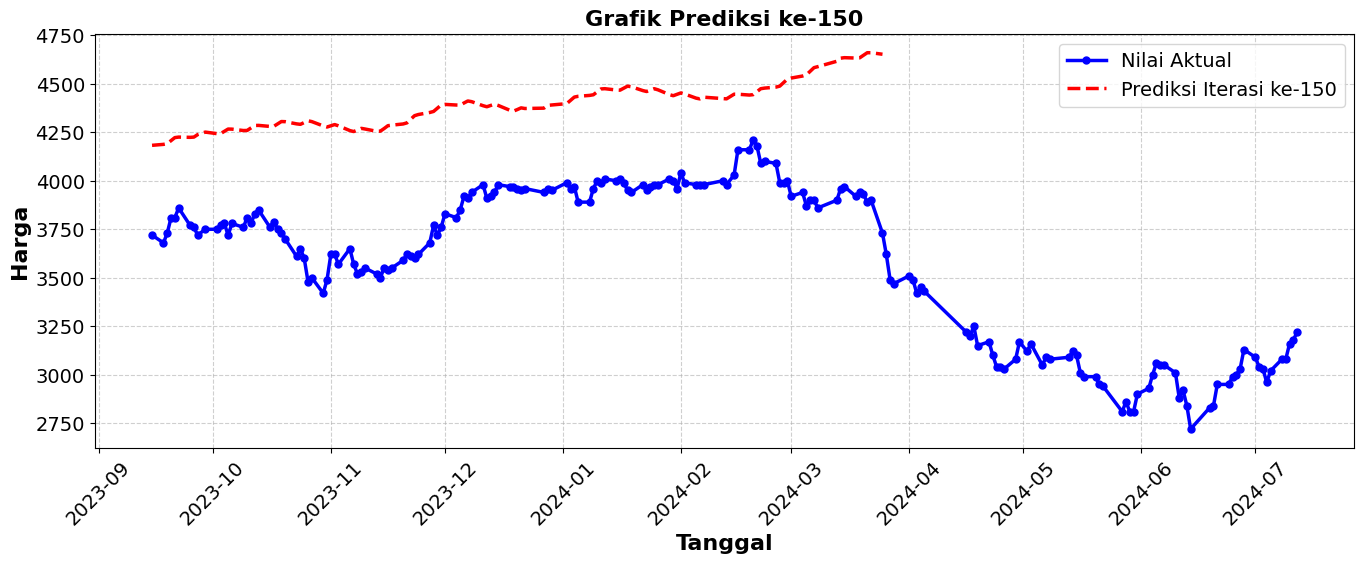

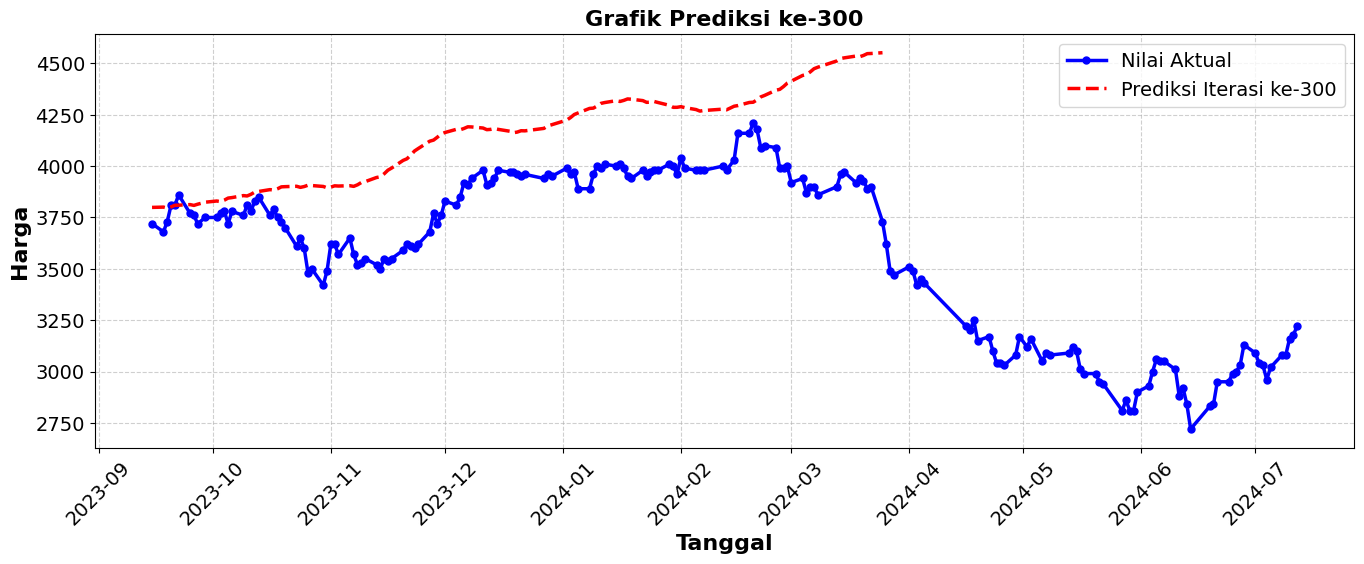

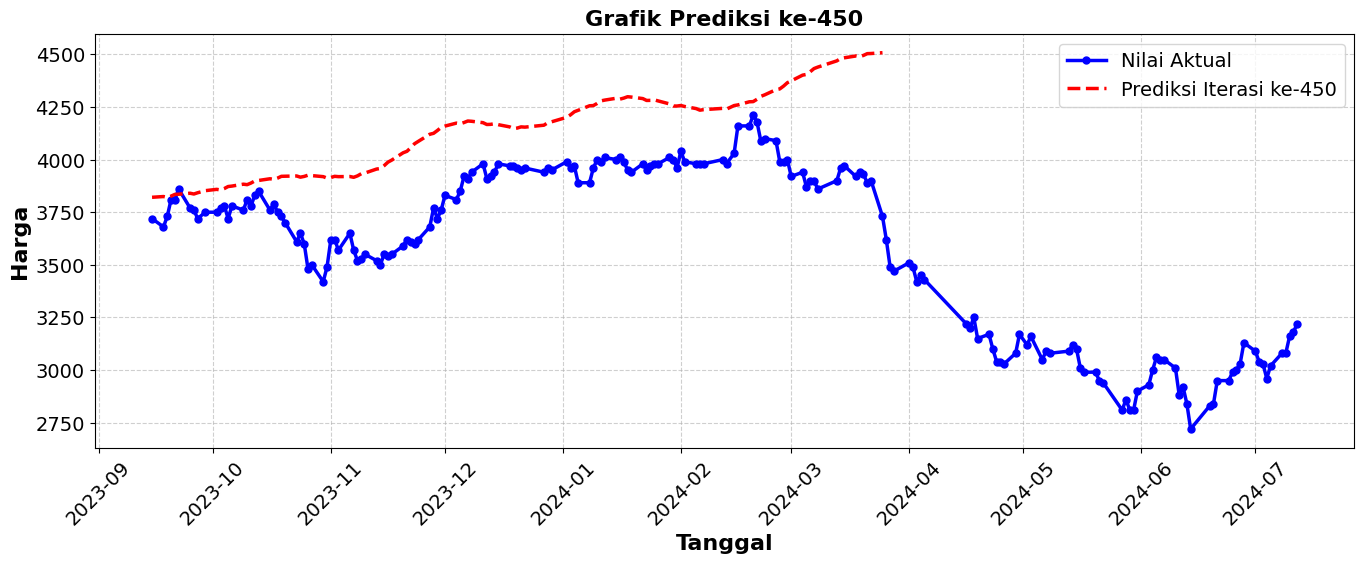

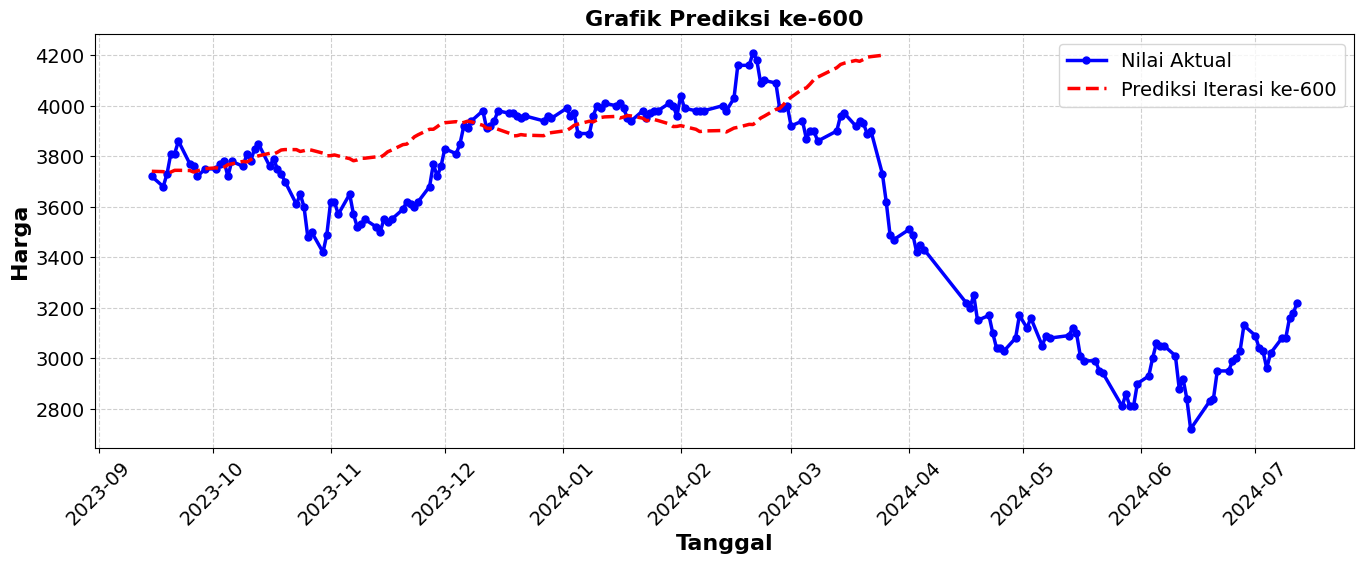

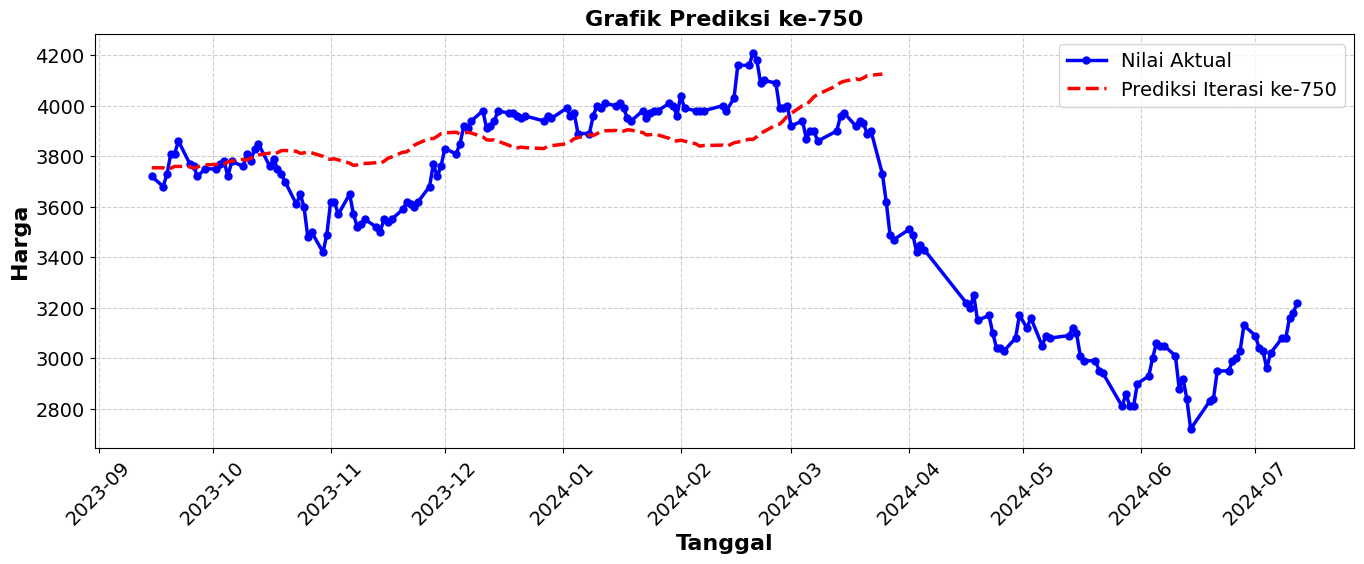

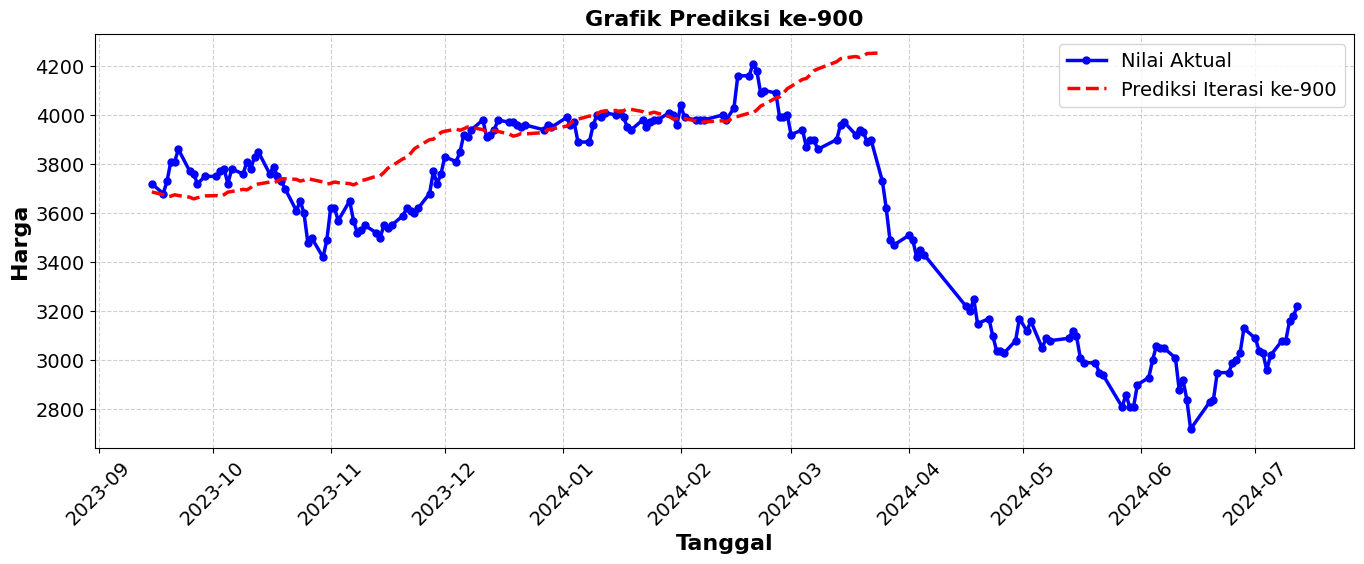

In [11]:
for i in target_iters:
    plt.figure(figsize=(14, 6))

    # Plot data aktual
    plt.plot(
        comparison_n['ds'],
        comparison_n['y'],
        label='Nilai Aktual',
        color='blue',
        linewidth=2.5,
        marker='o',
        markersize=5
    )

    # Plot data prediksi iterasi ke-i
    plt.plot(
        comparison_n['ds'],
        comparison_n[f'yhat_iterasi_{i}'],
        label=f'Prediksi Iterasi ke-{i}',
        color='red',
        linestyle='--',
        linewidth=2.5
    )

    # Elemen visual
    plt.title(f'Grafik Prediksi ke-{i}', fontsize=16, weight='bold')
    plt.xlabel('Tanggal', fontsize=16, weight='bold')
    plt.ylabel('Harga', fontsize=16, weight='bold')
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout(pad=2.0)  # padding agar tidak saling berhimpitan

    # Simpan grafik
    plt.savefig(f'grafik prediksi ke-{i}.png', dpi=300)  # simpan dengan kualitas tinggi
    plt.show()


In [12]:
print(f"Parameter Terbaik: {best_params}\nMAPE Terbaik: {best_mape:.2f}%")
print(f"Waktu yang dibutuhkan untuk tuning: {end_time - start_time:.2f} detik")

Parameter Terbaik: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}
MAPE Terbaik: 2.94%
Waktu yang dibutuhkan untuk tuning: 1241.64 detik


In [13]:
# Melatih model dengan parameter terbaik
model_tuned = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    interval_width=best_params['interval_width']
)
model_tuned.fit(train_data)


03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Melakukan prediksi dengan parameter terbaik
forecast_tuned = model_tuned.predict(future)

# Menampilkan hasil prediksi
print("Hasil Prediksi Dengan Tuning:")
print(forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Hasil Prediksi Dengan Tuning:
          ds         yhat   yhat_lower   yhat_upper
0 2020-07-13  3083.543751  3040.928667  3123.858406
1 2020-07-14  3071.972277  3029.873671  3115.774814
2 2020-07-15  3072.160913  3026.072905  3109.450997
3 2020-07-16  3075.012408  3027.309592  3114.022336
4 2020-07-17  3069.398611  3025.307561  3114.563157


In [16]:
# Visualisasi: Prediksi Dengan Tuning
plt.figure(figsize=(14, 6))

# Plot nilai aktual
# plt.plot(
#     comparison['ds'],
#     comparison['y'],
#     label='Nilai Aktual',
#     color='blue',
#     linewidth=2.5,
#     marker='o',
#     markersize=5
# )

# Plot hasil prediksi dengan tuning
plt.plot(
    comparison_n['ds'],
    comparison_n['Prediksi_Dengan_Tuning'],
    label='Prediksi Dengan Tuning',
    color='green',
    linestyle='-.',
    linewidth=2.5
)

# Elemen visual
plt.title('Prediksi Dengan Tuning', fontsize=16, weight='bold')
plt.xlabel('Tanggal', fontsize=16, weight='bold')
plt.ylabel('Harga', fontsize=16, weight='bold')
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=2.0)

# Simpan grafik
plt.savefig('grafik_3.png', dpi=300)
plt.show()


KeyError: 'Prediksi_Dengan_Tuning'

<Figure size 1400x600 with 0 Axes>

Tabel Perbandingan:
          ds     y  Prediksi_Tanpa_Tuning  Prediksi_Dengan_Tuning
0 2023-09-15  3720            3825.394559             3688.201020
1 2023-09-18  3680            3829.568218             3676.220545
2 2023-09-19  3730            3825.879759             3667.194764
3 2023-09-20  3810            3832.118492             3669.839484
4 2023-09-21  3810            3840.943925             3675.086836


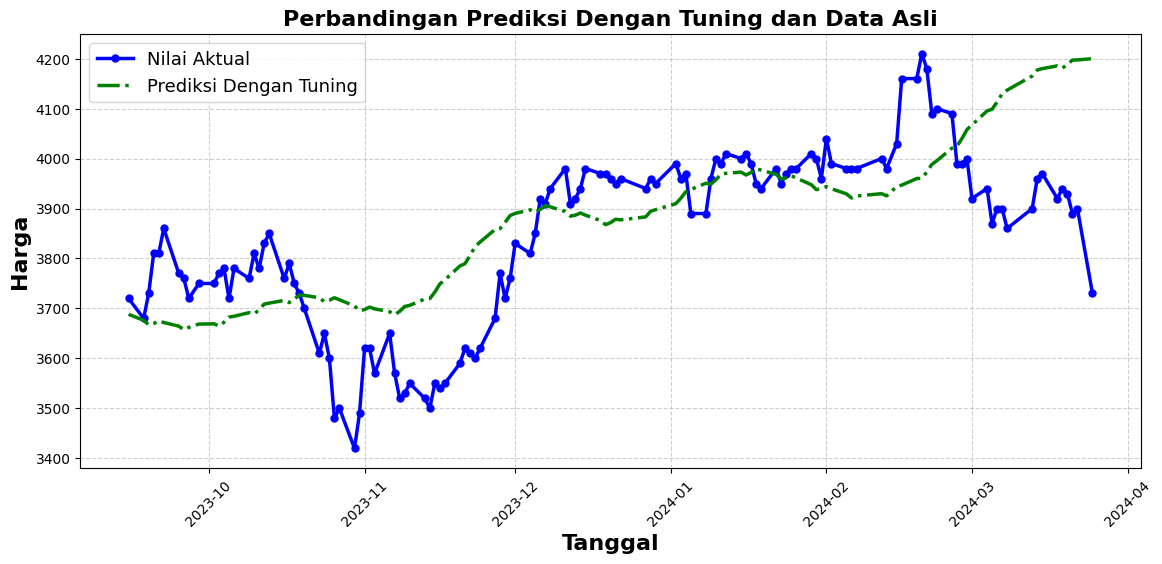

In [17]:
# Menggabungkan data uji dengan hasil prediksi tanpa dan dengan tuning
comparison = test_data.merge(
    forecast_default[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Tanpa_Tuning'}),
    on='ds'
).merge(
    forecast_tuned[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Dengan_Tuning'}),
    on='ds'
)


print("Tabel Perbandingan:")

print(comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].head())

plt.figure(figsize=(12, 6))
plt.plot(
    comparison['ds'], 
    comparison['y'], 
    label='Nilai Aktual', 
    color='blue', 
    marker='o',
    linewidth=2.5,
    markersize=5)

plt.plot(
    comparison['ds'],
    comparison['Prediksi_Dengan_Tuning'],
    label='Prediksi Dengan Tuning',
    color='green',
    linestyle='-.',
    linewidth=2.5)

plt.title('Perbandingan Prediksi Dengan Tuning dan Data Asli', fontsize=16, weight='bold')
plt.xlabel('Tanggal', fontsize=16, weight='bold')
plt.ylabel('Harga', fontsize=16, weight='bold')
plt.legend(fontsize=13)
plt.grid(True,  linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=2.0)

plt.savefig('grafik_4.png', dpi=300)
plt.show()

In [18]:
# Menyimpan data comparison ke dalam file Excel
comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].to_excel('comparison_table_2.xlsx', index=False)

print("Tabel perbandingan telah disimpan sebagai comparison_table_2.xlsx")

Tabel perbandingan telah disimpan sebagai comparison_table_2.xlsx


Tabel Perbandingan:
          ds     y  Prediksi_Tanpa_Tuning  Prediksi_Dengan_Tuning
0 2023-09-15  3720            3825.394559             3688.201020
1 2023-09-18  3680            3829.568218             3676.220545
2 2023-09-19  3730            3825.879759             3667.194764
3 2023-09-20  3810            3832.118492             3669.839484
4 2023-09-21  3810            3840.943925             3675.086836


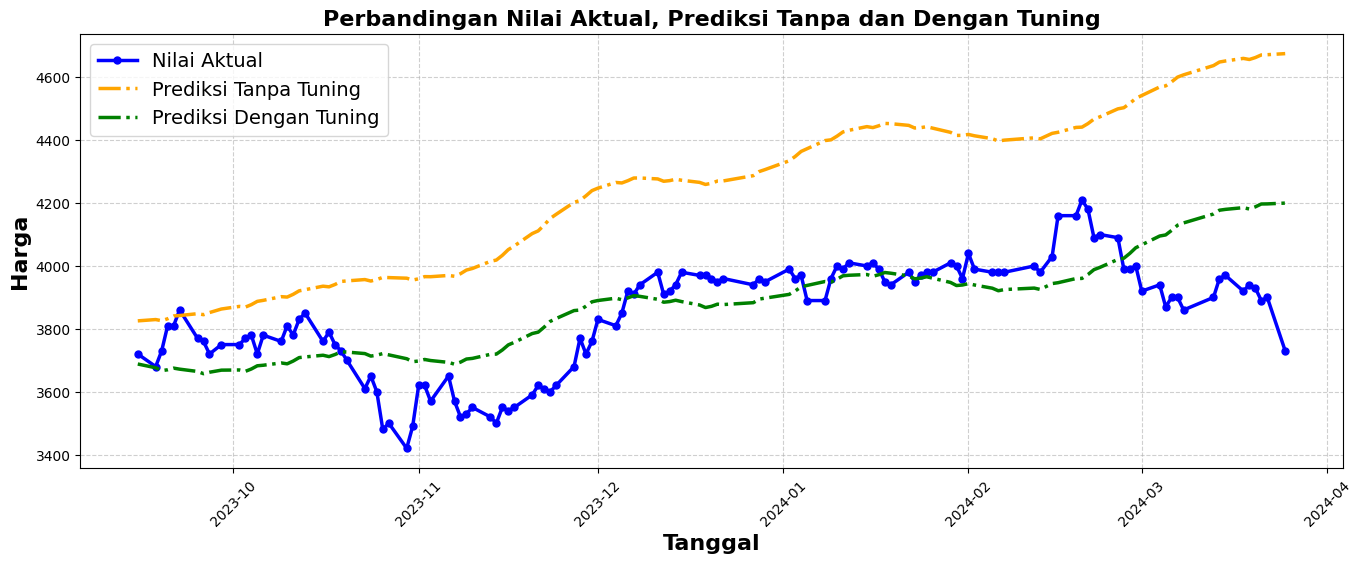

In [19]:
# Menggabungkan data uji dengan hasil prediksi tanpa dan dengan tuning
comparison = test_data.merge(
    forecast_default[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Tanpa_Tuning'}),
    on='ds'
).merge(
    forecast_tuned[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Dengan_Tuning'}),
    on='ds'
)

# Menampilkan tabel perbandingan
print("Tabel Perbandingan:")
print(comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].head())

# Visualisasi: Data Asli vs Tanpa Tuning vs Dengan Tuning
plt.figure(figsize=(14, 6))

# Nilai Aktual
plt.plot(
    comparison['ds'], 
    comparison['y'], 
    label='Nilai Aktual', 
    color='blue', 
    marker='o', 
    linewidth=2.5, 
    markersize=5
)

# Prediksi Tanpa Tuning
plt.plot(
    comparison['ds'], 
    comparison['Prediksi_Tanpa_Tuning'], 
    label='Prediksi Tanpa Tuning', 
    color='orange', 
    linestyle='-.', 
    linewidth=2.5
)

# Prediksi Dengan Tuning
plt.plot(
    comparison['ds'], 
    comparison['Prediksi_Dengan_Tuning'], 
    label='Prediksi Dengan Tuning', 
    color='green', 
    linestyle='-.', 
    linewidth=2.5
)

# Elemen visual tambahan
plt.title('Perbandingan Nilai Aktual, Prediksi Tanpa dan Dengan Tuning', fontsize=16, weight='bold')
plt.xlabel('Tanggal', fontsize=16, weight='bold')
plt.ylabel('Harga', fontsize=16, weight='bold')
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=2.0)

# Simpan jika dibutuhkan
plt.savefig('grafik_5.png', dpi=300)

plt.show()
